<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/Assignment_02_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>






<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 02 - Part 1
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

<div class="alert alert-block alert-info">
<b>The CIFAR-10 dataset</b><br>
https://www.cs.toronto.edu/~kriz/cifar.html
    </div>

## Imports

In [1]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [2]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

## Verify TensorFlow Version and Keras Version

In [3]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [4]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


## Mount Google Drive to Colab environment

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## EDA Functions

In [6]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [7]:
def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

## Research Assignment Reporting Functions

In [8]:
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [9]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [10]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [11]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [12]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t\t{}'.format(x_test.shape))
print('test_labels:\t\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


## Review Labels 

In [13]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


## Plot Subset of Examples

In [14]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [15]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
x_preview, y_preview = get_three_classes(test_images, test_labels)

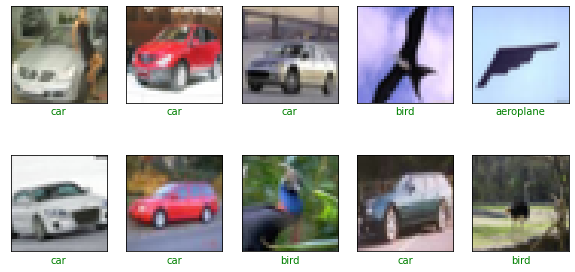

In [16]:
class_names_preview = ['aeroplane', 'car', 'bird']

show_random_examples(x_preview, y_preview, y_preview)

## Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [17]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

## Create Validation Data Set

In [18]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

## Confirm Datasets {Train, Validation, Test}

In [19]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Rescale Examples  {Train, Validation, Test}
The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [20]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

print(x_train_norm.shape, x_valid_norm.shape, x_test_norm.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


##Experiment 1: DNN with 2 layers (no regularization)

Hidden layer 1: 100 neurons

Hidden layer 2: 150 neurons

Ouput layer: 10 neurons (one for each image)

####Build, Compile, Train, Evaluate

In [21]:
## Variation 1 - did not train
#model_1 = Sequential()
#model_1.add(Dense(input_shape = [32,32,3], units = 100, activation = 'relu', ))
#model_1.add(Dense(units = 150, activation = 'relu'))
#model_1.add(Dense(name = "output_layer", units = 10, activation = 'softmax'))
#model_1.summary()

In [22]:
## Variation 2 - trained 
from time import perf_counter 
model_1 = Sequential()
model_1.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_1.add(layers.Dense(units = 100, activation = "relu"))
model_1.add(layers.Dense(units = 150, activation = "relu"))
model_1.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 100)               307300    
                                                                 
 dense_1 (Dense)             (None, 150)               15150     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 323,960
Trainable params: 323,960
Non-trainable params: 0
_________________________________________________________________


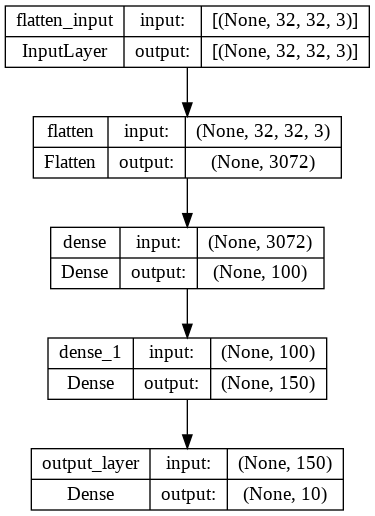

In [23]:
keras.utils.plot_model(model_1, "CIFAR_model.png", show_shapes=True) 

In [24]:
## Compile

model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [25]:
## Train 
time = perf_counter()

history_1 = model_1.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_1.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 5s 3ms/step - loss: 1.8717 - accuracy: 0.3224 - val_loss: 1.7387 - val_accuracy: 0.3738
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6879 - accuracy: 0.3960 - val_loss: 1.7261 - val_accuracy: 0.3858
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6236 - accuracy: 0.4210 - val_loss: 1.6374 - val_accuracy: 0.4104
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5609 - accuracy: 0.4422 - val_loss: 1.5654 - val_accuracy: 0.4392
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5280 - accuracy: 0.4535 - val_loss: 1.6520 - val_accuracy: 0.4238
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5003 - accuracy: 0.4644 - val_loss: 1.5393 - val_accuracy: 0.4480
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4774 - accuracy: 0.4742 - val_loss: 1.5611 - val_accuracy: 0.4352

In [26]:
time_1 = perf_counter() - time
print(time_1)

25.7474269920001


In [27]:
## Evaluate

model_1 = tf.keras.models.load_model("DNN_model_1.h5")
print(f"Test acc: {model_1.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4812 - accuracy: 0.4706
Test acc: 0.471


#### Plot Metrics

In [28]:
history_dict_1 = history_1.history
history_dict_1.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
history_df_1=pd.DataFrame(history_dict_1)
history_df_1.tail().round(3)

loss  accuracy  val_loss  val_accuracy
6   1.477     0.474     1.561         0.435
7   1.453     0.482     1.520         0.459
8   1.438     0.487     1.515         0.451
9   1.422     0.494     1.591         0.436
10  1.409     0.497     1.542         0.448

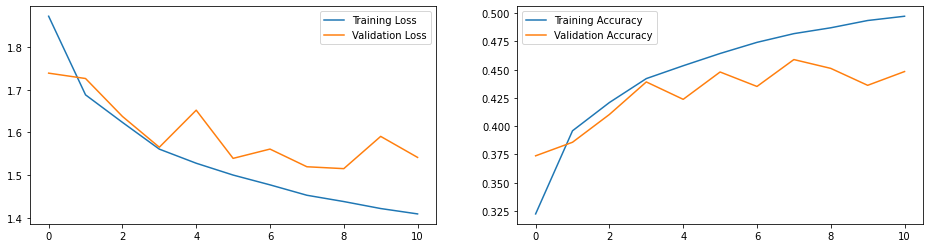

In [30]:
## Loss and acuracy
plot_history(history_1)

In [31]:
## Confusion matrix
pred_1= model_1.predict(x_test_norm)
pred_1=np.argmax(pred_1, axis=1)

313/313 [==============================] - 1s 1ms/step


313/313 [==============================] - 0s 1ms/step


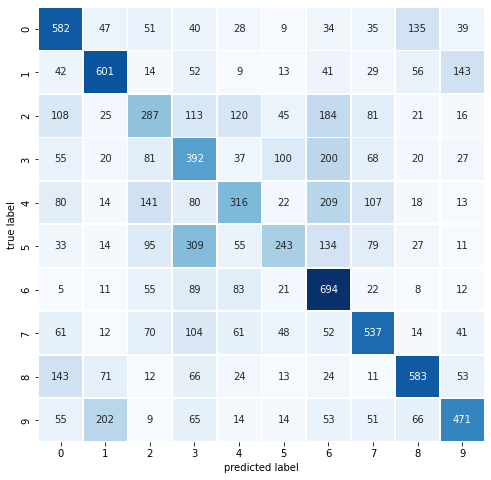

In [32]:
# Get the predicted classes:
pred_classes_1 = np.argmax(model_1.predict(x_test_norm), axis=-1)
pred_classes_1;

conf_mx_1 = tf.math.confusion_matrix(y_test, pred_classes_1)
conf_mx_1;

plot_confusion_matrix(y_test,pred_classes_1)

#### Activation and Performance

In [33]:
# Extracts the outputs of all layers:
layer_outputs_1 = [layer.output for layer in model_1.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_1 = models.Model(inputs=model_1.input, outputs=layer_outputs_1)

# Get activation values for the last dense layer
activations_1 = activation_model_1.predict(x_valid_norm[:3250])
dense_layer_activations_1 = activations_1[-3]
output_layer_activations_1 = activations_1[-1]

102/102 [==============================] - 0s 1ms/step


In [34]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_1 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_1 = tsne_1.fit_transform(dense_layer_activations_1)

# Scaling
tsne_results_1 = (tsne_results_1 - tsne_results_1.min()) / (tsne_results_1.max() - tsne_results_1.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 3250 samples in 0.241s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 4.715673
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.684128
[t-SNE] KL divergence after 300 iterations: 2.405249


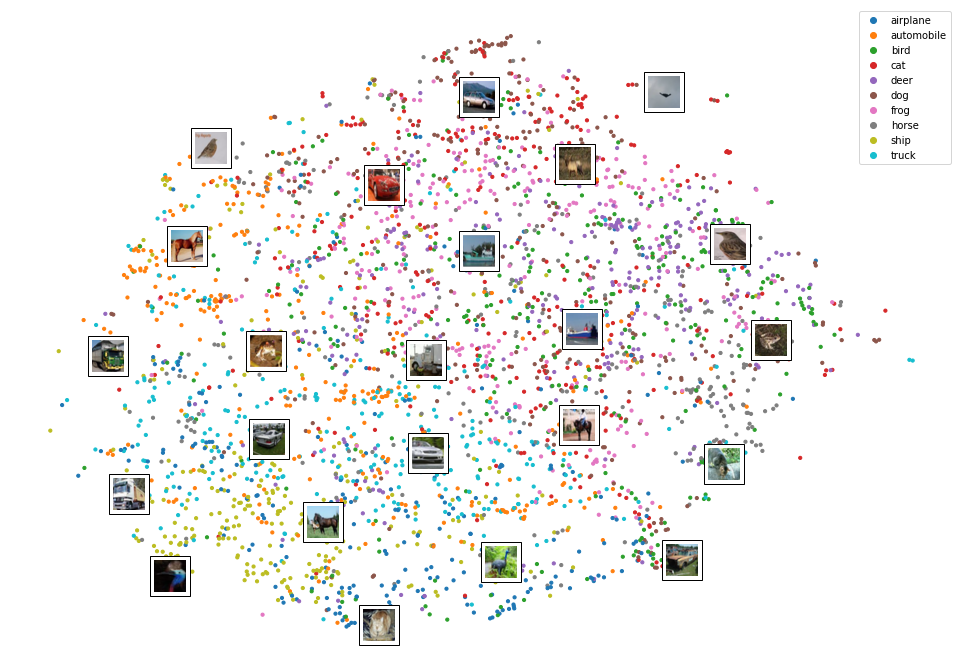

In [35]:
cmap_1 = plt.cm.tab10
plt.figure(figsize=(17,12))
scatter_1 = plt.scatter(tsne_results_1[:,0],tsne_results_1[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_1)
plt.legend(handles=scatter_1.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_1):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

##Experiment 2: DNN with 3 layers (no regularization)

Hidden layer 1: 100

Hidden layer 2: 150

Hidden layer 3: 75

Output layer: 10 (one for each image)

#### Build, Compile, Train, Evaluate

In [36]:
model_2 = Sequential()
model_2.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_2.add(layers.Dense(units = 100, activation = "relu"))
model_2.add(layers.Dense(units = 250, activation = "relu"))
model_2.add(layers.Dense(units = 150, activation = "relu"))
model_2.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_2 (Dense)             (None, 100)               307300    
                                                                 
 dense_3 (Dense)             (None, 250)               25250     
                                                                 
 dense_4 (Dense)             (None, 150)               37650     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 371,710
Trainable params: 371,710
Non-trainable params: 0
_________________________________________________________________


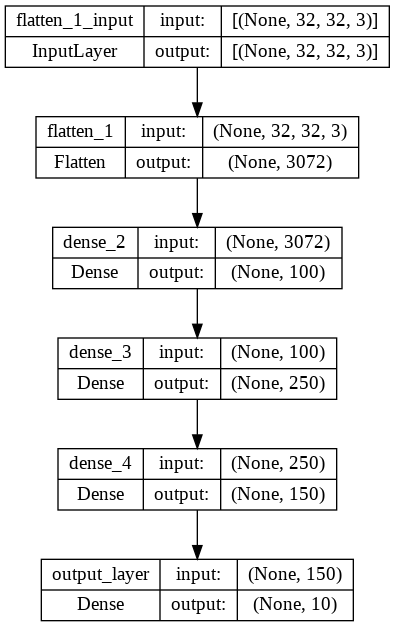

In [37]:
keras.utils.plot_model(model_2, "CIFAR_model.png", show_shapes=True) 

In [38]:
## Compile

model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [39]:
## Train 
time = perf_counter()

history_2 = model_2.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_2.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 3ms/step - loss: 1.8640 - accuracy: 0.3208 - val_loss: 1.7340 - val_accuracy: 0.3668
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6835 - accuracy: 0.3951 - val_loss: 1.7216 - val_accuracy: 0.3806
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6003 - accuracy: 0.4238 - val_loss: 1.6025 - val_accuracy: 0.4202
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5524 - accuracy: 0.4450 - val_loss: 1.6408 - val_accuracy: 0.4164
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5097 - accuracy: 0.4605 - val_loss: 1.5800 - val_accuracy: 0.4270
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4809 - accuracy: 0.4689 - val_loss: 1.6411 - val_accuracy: 0.4094
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4546 - accuracy: 0.4792 - val_loss: 1.5102 - val_accuracy: 0.4600

In [40]:
time_2 = perf_counter() - time
print(time_2)

21.59072158799995


In [41]:
## Evaluate

model_2 = tf.keras.models.load_model("DNN_model_2.h5")
print(f"Test acc: {model_2.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4753 - accuracy: 0.4725
Test acc: 0.472


#### Plot Metrics

In [42]:
history_dict_2 = history_2.history
history_dict_2.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [43]:
history_df_2=pd.DataFrame(history_dict_2)
history_df_2.tail().round(3)

loss  accuracy  val_loss  val_accuracy
5  1.481     0.469     1.641         0.409
6  1.455     0.479     1.510         0.460
7  1.428     0.489     1.584         0.433
8  1.406     0.495     1.490         0.458
9  1.376     0.506     1.525         0.456

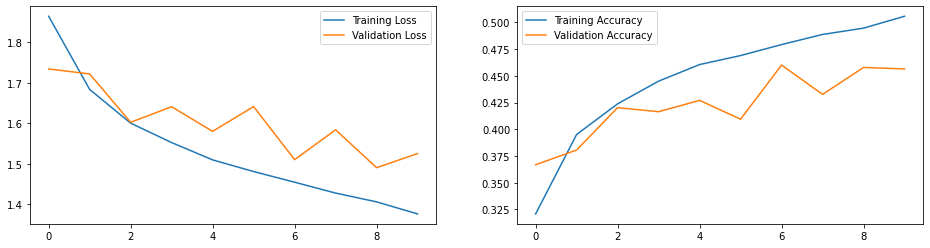

In [44]:
## Loss and acuracy
plot_history(history_2)

In [45]:
## Confusion matrix
pred_2= model_2.predict(x_test_norm)
pred_2=np.argmax(pred_2, axis=1)

313/313 [==============================] - 0s 1ms/step


313/313 [==============================] - 0s 1ms/step


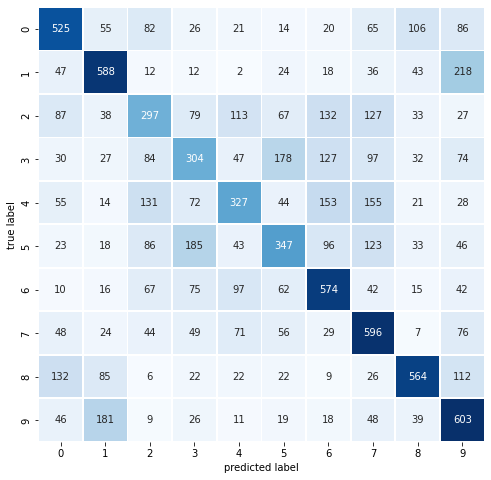

In [46]:
# Get the predicted classes:
pred_classes_2 = np.argmax(model_2.predict(x_test_norm), axis=-1)
pred_classes_2;

conf_mx_2 = tf.math.confusion_matrix(y_test, pred_classes_2)
conf_mx_2;

plot_confusion_matrix(y_test,pred_classes_2)

#### Activation and Performance

In [47]:
# Extracts the outputs of all layers:
layer_outputs_2 = [layer.output for layer in model_2.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_2 = models.Model(inputs=model_2.input, outputs=layer_outputs_2)

# Get activation values for the last dense layer
activations_2 = activation_model_2.predict(x_valid_norm[:3250])
dense_layer_activations_2 = activations_2[-3]
output_layer_activations_2 = activations_2[-1]

102/102 [==============================] - 0s 2ms/step


In [48]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_2 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_2 = tsne_2.fit_transform(dense_layer_activations_2)

# Scaling
tsne_results_2 = (tsne_results_2 - tsne_results_2.min()) / (tsne_results_2.max() - tsne_results_2.min())

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.001s...


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computed neighbors for 3250 samples in 0.253s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 2.869989
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.468079
[t-SNE] KL divergence after 300 iterations: 2.290381


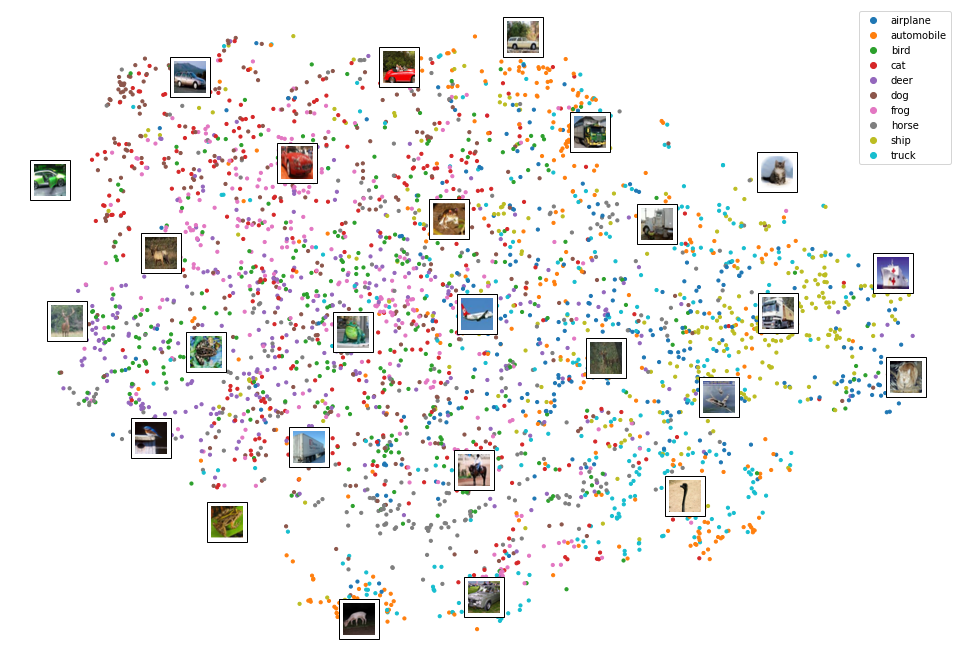

In [49]:
cmap_2 = plt.cm.tab10
plt.figure(figsize=(17,12))
scatter_2 = plt.scatter(tsne_results_2[:,0],tsne_results_2[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_2)
plt.legend(handles=scatter_2.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_2):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

##Experiment 3: CNN with 2 convolution/max pooling layers (no regularization)

Layer 1: 128

Layer 2: 256

Layer: 384

#### Build, Compile, Train, Evaluate

In [50]:
## Build CNN

model_3 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), # Layer 1 end
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), # Layer 2 end
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.softmax)       
])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 9216)              0         
                                                                 
 dense_5 (Dense)             (None, 384)              

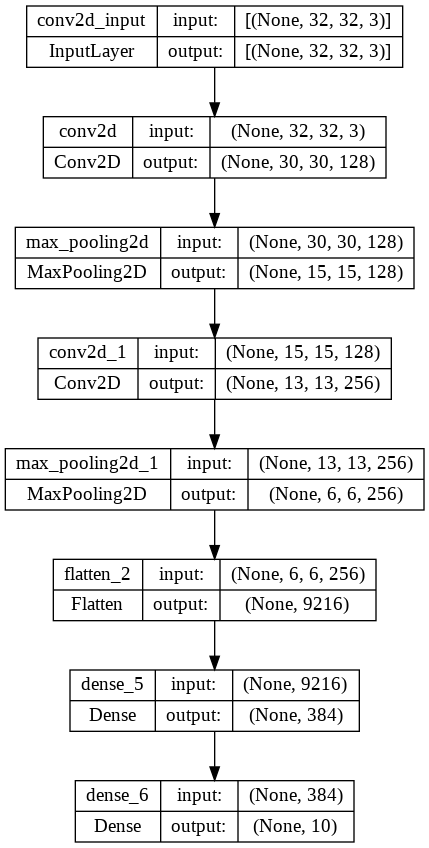

In [51]:
keras.utils.plot_model(model_3, "CIFAR10.png", show_shapes=True) 

In [52]:
## Compile

model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [53]:
## Train 
time = perf_counter()

history_3 = model_3.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_3.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 14s 10ms/step - loss: 2.1718 - accuracy: 0.1750 - val_loss: 2.0551 - val_accuracy: 0.1708
Epoch 2/200
704/704 [==============================] - 7s 10ms/step - loss: 2.0044 - accuracy: 0.1852 - val_loss: 1.9812 - val_accuracy: 0.1908
Epoch 3/200
704/704 [==============================] - 7s 10ms/step - loss: 1.9191 - accuracy: 0.2296 - val_loss: 1.8629 - val_accuracy: 0.2496
Epoch 4/200
704/704 [==============================] - 7s 10ms/step - loss: 1.8154 - accuracy: 0.2690 - val_loss: 1.7868 - val_accuracy: 0.2712
Epoch 5/200
704/704 [==============================] - 7s 10ms/step - loss: 1.7439 - accuracy: 0.2881 - val_loss: 1.7254 - val_accuracy: 0.2842
Epoch 6/200
704/704 [==============================] - 7s 10ms/step - loss: 1.6926 - accuracy: 0.3005 - val_loss: 1.7008 - val_accuracy: 0.2992
Epoch 7/200
704/704 [==============================] - 7s 10ms/step - loss: 1.6506 - accuracy: 0.3196 - val_loss: 1.6688 - val_accuracy

In [54]:
time_3 = perf_counter() - time
print(time_3)

274.5799246249999


In [55]:
## Evaluate

model_3 = tf.keras.models.load_model("CNN_model_3.h5")
print(f"Test acc: {model_3.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.1882 - accuracy: 0.6047
Test acc: 0.605


#### Plot Metrics

In [56]:
history_dict_3 = history_3.history
history_dict_3.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [57]:
history_df_3=pd.DataFrame(history_dict_3)
history_df_3.tail().round(3)

loss  accuracy  val_loss  val_accuracy
34  0.686     0.774     1.198         0.631
35  0.674     0.778     1.198         0.638
36  0.653     0.787     1.206         0.636
37  0.644     0.793     1.265         0.628
38  0.635     0.799     1.254         0.635

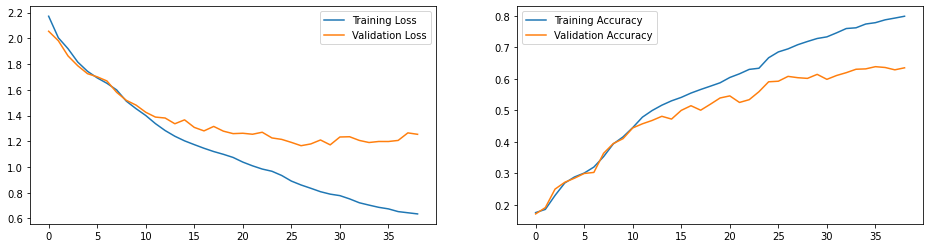

In [58]:
## Loss and acuracy
plot_history(history_3)

In [59]:
## Confusion matrix
pred_3= model_3.predict(x_test_norm)
pred_3=np.argmax(pred_3, axis=1)

313/313 [==============================] - 1s 2ms/step


313/313 [==============================] - 1s 2ms/step


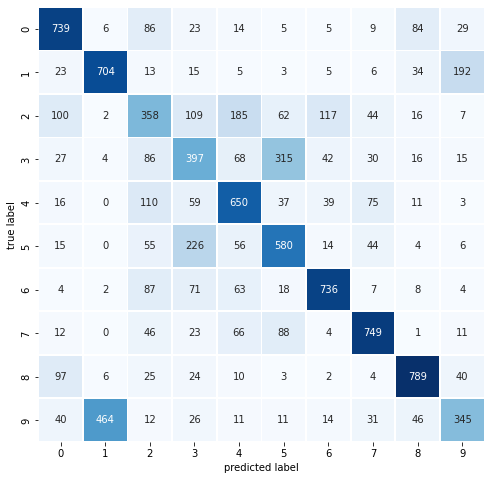

In [60]:
# Get the predicted classes:
pred_classes_3 = np.argmax(model_3.predict(x_test_norm), axis=-1)
pred_classes_3;

conf_mx_3 = tf.math.confusion_matrix(y_test, pred_classes_3)
conf_mx_3;

plot_confusion_matrix(y_test,pred_classes_3)

#### Activation and Performance

In [61]:
# Extracts the outputs of all layers:
layer_outputs_3 = [layer.output for layer in model_3.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_3 = models.Model(inputs=model_3.input, outputs=layer_outputs_3)

# Get activation values for the last dense layer
activations_3 = activation_model_3.predict(x_valid_norm[:3250])
dense_layer_activations_3 = activations_3[-3]
output_layer_activations_3 = activations_3[-1]

102/102 [==============================] - 0s 2ms/step


In [62]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_3 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_3 = tsne_3.fit_transform(dense_layer_activations_3)

# Scaling
tsne_results_3 = (tsne_results_3 - tsne_results_3.min()) / (tsne_results_3.max() - tsne_results_3.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.021s...
[t-SNE] Computed neighbors for 3250 samples in 2.425s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 4.040850
[t-SNE] KL divergence after 250 iterations with early exaggeration: 140.944855
[t-SNE] KL divergence after 300 iterations: 5.583576


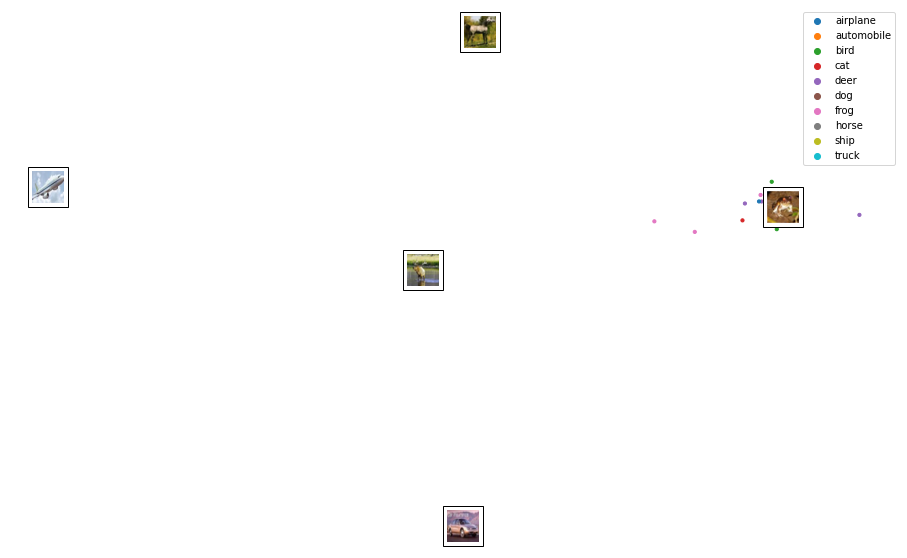

In [63]:
cmap_3 = plt.cm.tab10
plt.figure(figsize=(16,10))
scatter_3 = plt.scatter(tsne_results_3[:,0],tsne_results_3[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_3)
plt.legend(handles=scatter_3.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_3):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#### Predictions

In [64]:
model_3 = tf.keras.models.load_model('CNN_model_3.h5')
preds_3 = model_3.predict(x_test_norm)
preds_3.shape

313/313 [==============================] - 1s 2ms/step


(10000, 10)

In [65]:
cm_3 = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [66]:
df_3 = pd.DataFrame(preds_3[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df_3.style.format("{:.2%}").background_gradient(cmap=cm_3)

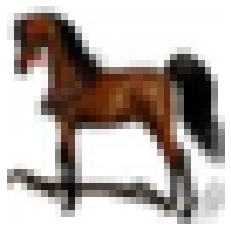

In [67]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img_3 = test_images[2004]
img_tensor_3 = image.img_to_array(img_3)
img_tensor_3 = np.expand_dims(img_tensor_3, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img_3, cmap='viridis')
plt.axis('off')
plt.show()

In [68]:
# Extracts the outputs of the top 8 layers:
layer_outputs_3 = [layer.output for layer in model_3.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_3 = models.Model(inputs=model_3.input, outputs=layer_outputs_3)

In [69]:
activations_3 = activation_model_3.predict(img_tensor_3)
len(activations_3)

1/1 [==============================] - 0s 98ms/step


7

In [70]:
layer_names = []
for layer in model_3.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d',
 'max_pooling2d',
 'conv2d_1',
 'max_pooling2d_1',
 'flatten_2',
 'dense_5',
 'dense_6']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


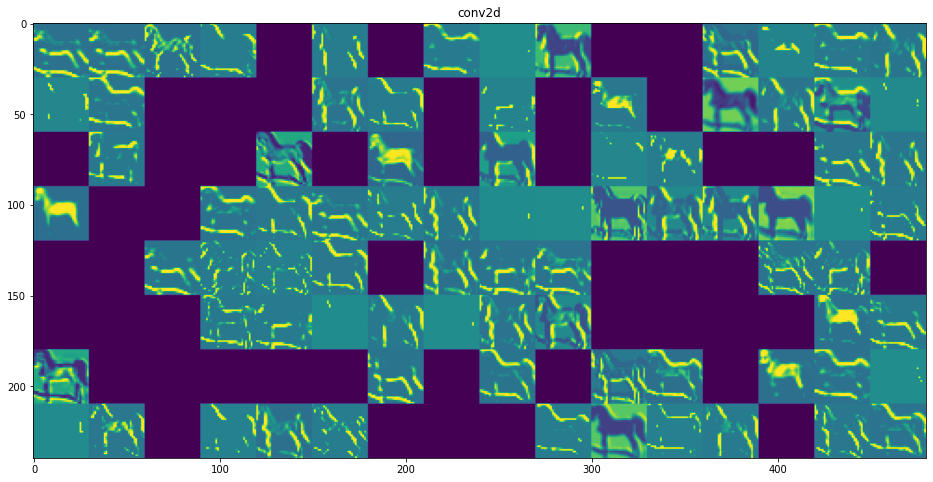

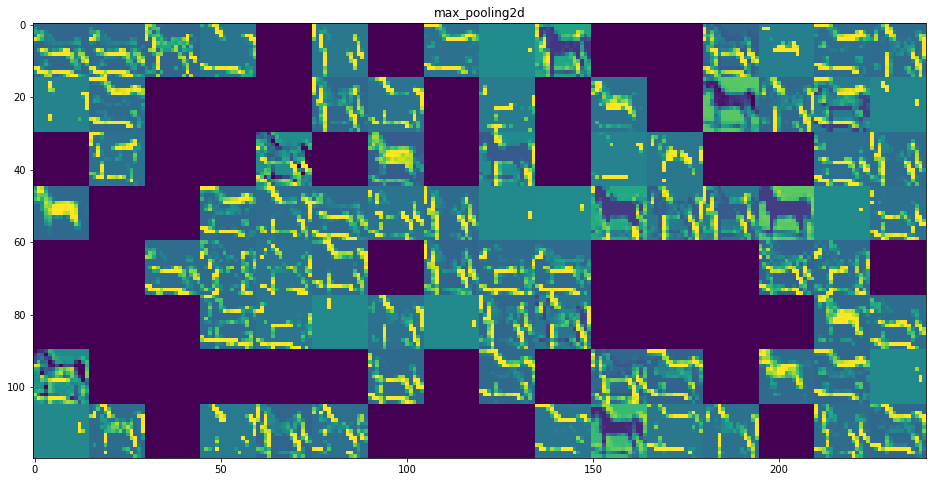

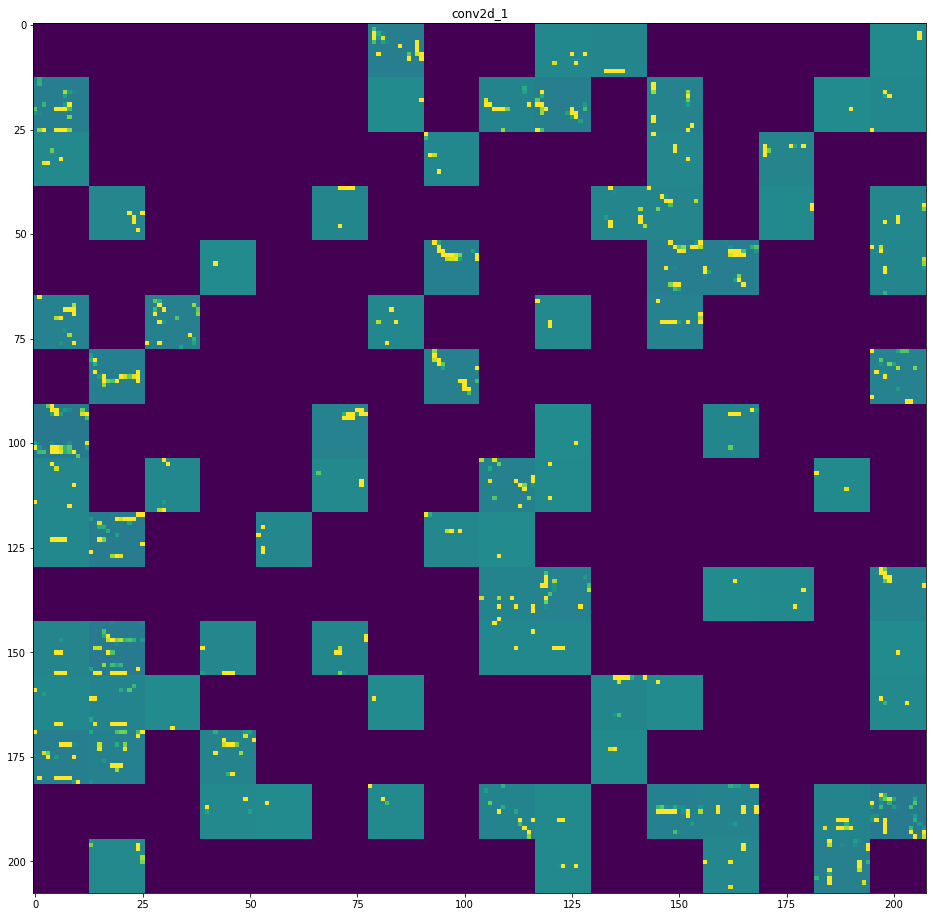

In [71]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_3.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_3):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

##Experiment 4: CNN with 2 convolution/max pooling layers (no regularization)

Layer 1: 128

Layer 2: 256

Layer 3: 512

Layer: 384

#### Build, Compile, Train, Evaluate

In [72]:
## Build CNN

model_4 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), #Start of Layer 1
  MaxPool2D((2, 2),strides=2), #End of Layer 1
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), #Start of Layer 2
  MaxPool2D((2, 2),strides=2), #End of Layer 2
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), #Start of Layer 3
  MaxPool2D((2, 2),strides=2), #End of Layer 3
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification
  BatchNormalization(),
  Dense(units=10, activation=tf.nn.softmax)       
])
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 512)         1180160   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 512)       

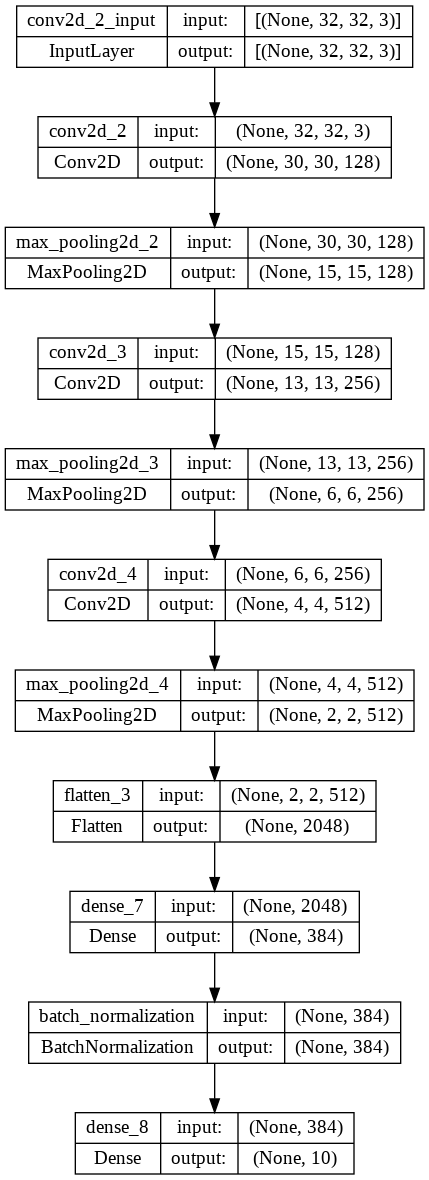

In [73]:
keras.utils.plot_model(model_4, "CIFAR10.png", show_shapes=True) 

In [74]:
## Compile
model_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [75]:
## Train
time = perf_counter()

history_4 = model_4.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_4.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 9s 12ms/step - loss: 1.5207 - accuracy: 0.4680 - val_loss: 1.4216 - val_accuracy: 0.5136
Epoch 2/200
704/704 [==============================] - 8s 11ms/step - loss: 1.0895 - accuracy: 0.6374 - val_loss: 1.1046 - val_accuracy: 0.6376
Epoch 3/200
704/704 [==============================] - 8s 12ms/step - loss: 0.8999 - accuracy: 0.7088 - val_loss: 1.0137 - val_accuracy: 0.6678
Epoch 4/200
704/704 [==============================] - 8s 12ms/step - loss: 0.7775 - accuracy: 0.7534 - val_loss: 0.8666 - val_accuracy: 0.7314
Epoch 5/200
704/704 [==============================] - 8s 12ms/step - loss: 0.6674 - accuracy: 0.7933 - val_loss: 0.9873 - val_accuracy: 0.6922
Epoch 6/200
704/704 [==============================] - 8s 12ms/step - loss: 0.5785 - accuracy: 0.8271 - val_loss: 0.9507 - val_accuracy: 0.7174
Epoch 7/200
704/704 [==============================] - 8s 11ms/step - loss: 0.4971 - accuracy: 0.8563 - val_loss: 0.8962 - val_accuracy:

In [76]:
time_4 = perf_counter() - time
print(time_4)

106.61792762999994


In [77]:
## Evalute

model_4 = tf.keras.models.load_model("CNN_model_4.h5")
print(f"Test acc: {model_4.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.8884 - accuracy: 0.7197
Test acc: 0.720


#### Plot Metrics

In [78]:
history_dict_4 = history_4.history
history_dict_4.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [79]:
history_df_4=pd.DataFrame(history_dict_4)
history_df_4.tail().round(3)

loss  accuracy  val_loss  val_accuracy
8   0.367     0.904     1.043         0.725
9   0.323     0.920     1.062         0.742
10  0.290     0.930     1.229         0.705
11  0.257     0.942     1.168         0.732
12  0.247     0.945     1.334         0.711

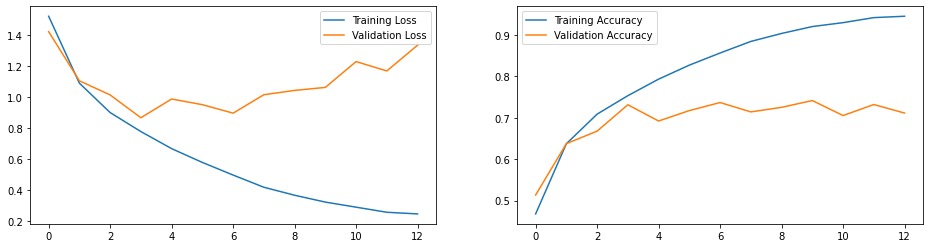

In [80]:
## Loss and acuracy
plot_history(history_4)

In [81]:
## Confusion matrix
pred_4= model_4.predict(x_test_norm)
pred_4=np.argmax(pred_4, axis=1)

313/313 [==============================] - 1s 3ms/step


313/313 [==============================] - 1s 3ms/step


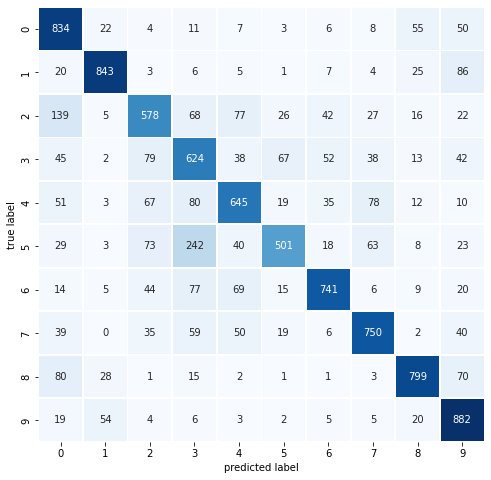

In [82]:
# Get the predicted classes:
pred_classes_4 = np.argmax(model_4.predict(x_test_norm), axis=-1)
pred_classes_4;

conf_mx_4 = tf.math.confusion_matrix(y_test, pred_classes_4)
conf_mx_4;

plot_confusion_matrix(y_test,pred_classes_4)

#### Activation and Performance

In [83]:
# Extracts the outputs of all layers:
layer_outputs_4 = [layer.output for layer in model_4.layers]

# Creates a model that will return these outputs, given the model input:
activation_model_4 = models.Model(inputs=model_4.input, outputs=layer_outputs_4)

# Get activation values for the last dense layer
activations_4 = activation_model_4.predict(x_valid_norm[:3250])
dense_layer_activations_4 = activations_4[-3]
output_layer_activations_4 = activations_4[-1]

102/102 [==============================] - 0s 3ms/step


In [84]:
## TSNE
# Reduce the dimension using T-SNE to visualize i n a scatterplot
tsne_4 = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_4 = tsne_3.fit_transform(dense_layer_activations_4)

# Scaling
tsne_results_3 = (tsne_results_3 - tsne_results_3.min()) / (tsne_results_3.max() - tsne_results_3.min())

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3250 samples in 0.002s...
[t-SNE] Computed neighbors for 3250 samples in 0.330s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3250
[t-SNE] Computed conditional probabilities for sample 2000 / 3250
[t-SNE] Computed conditional probabilities for sample 3000 / 3250
[t-SNE] Computed conditional probabilities for sample 3250 / 3250
[t-SNE] Mean sigma: 0.059634
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.450317
[t-SNE] KL divergence after 300 iterations: 1.756842


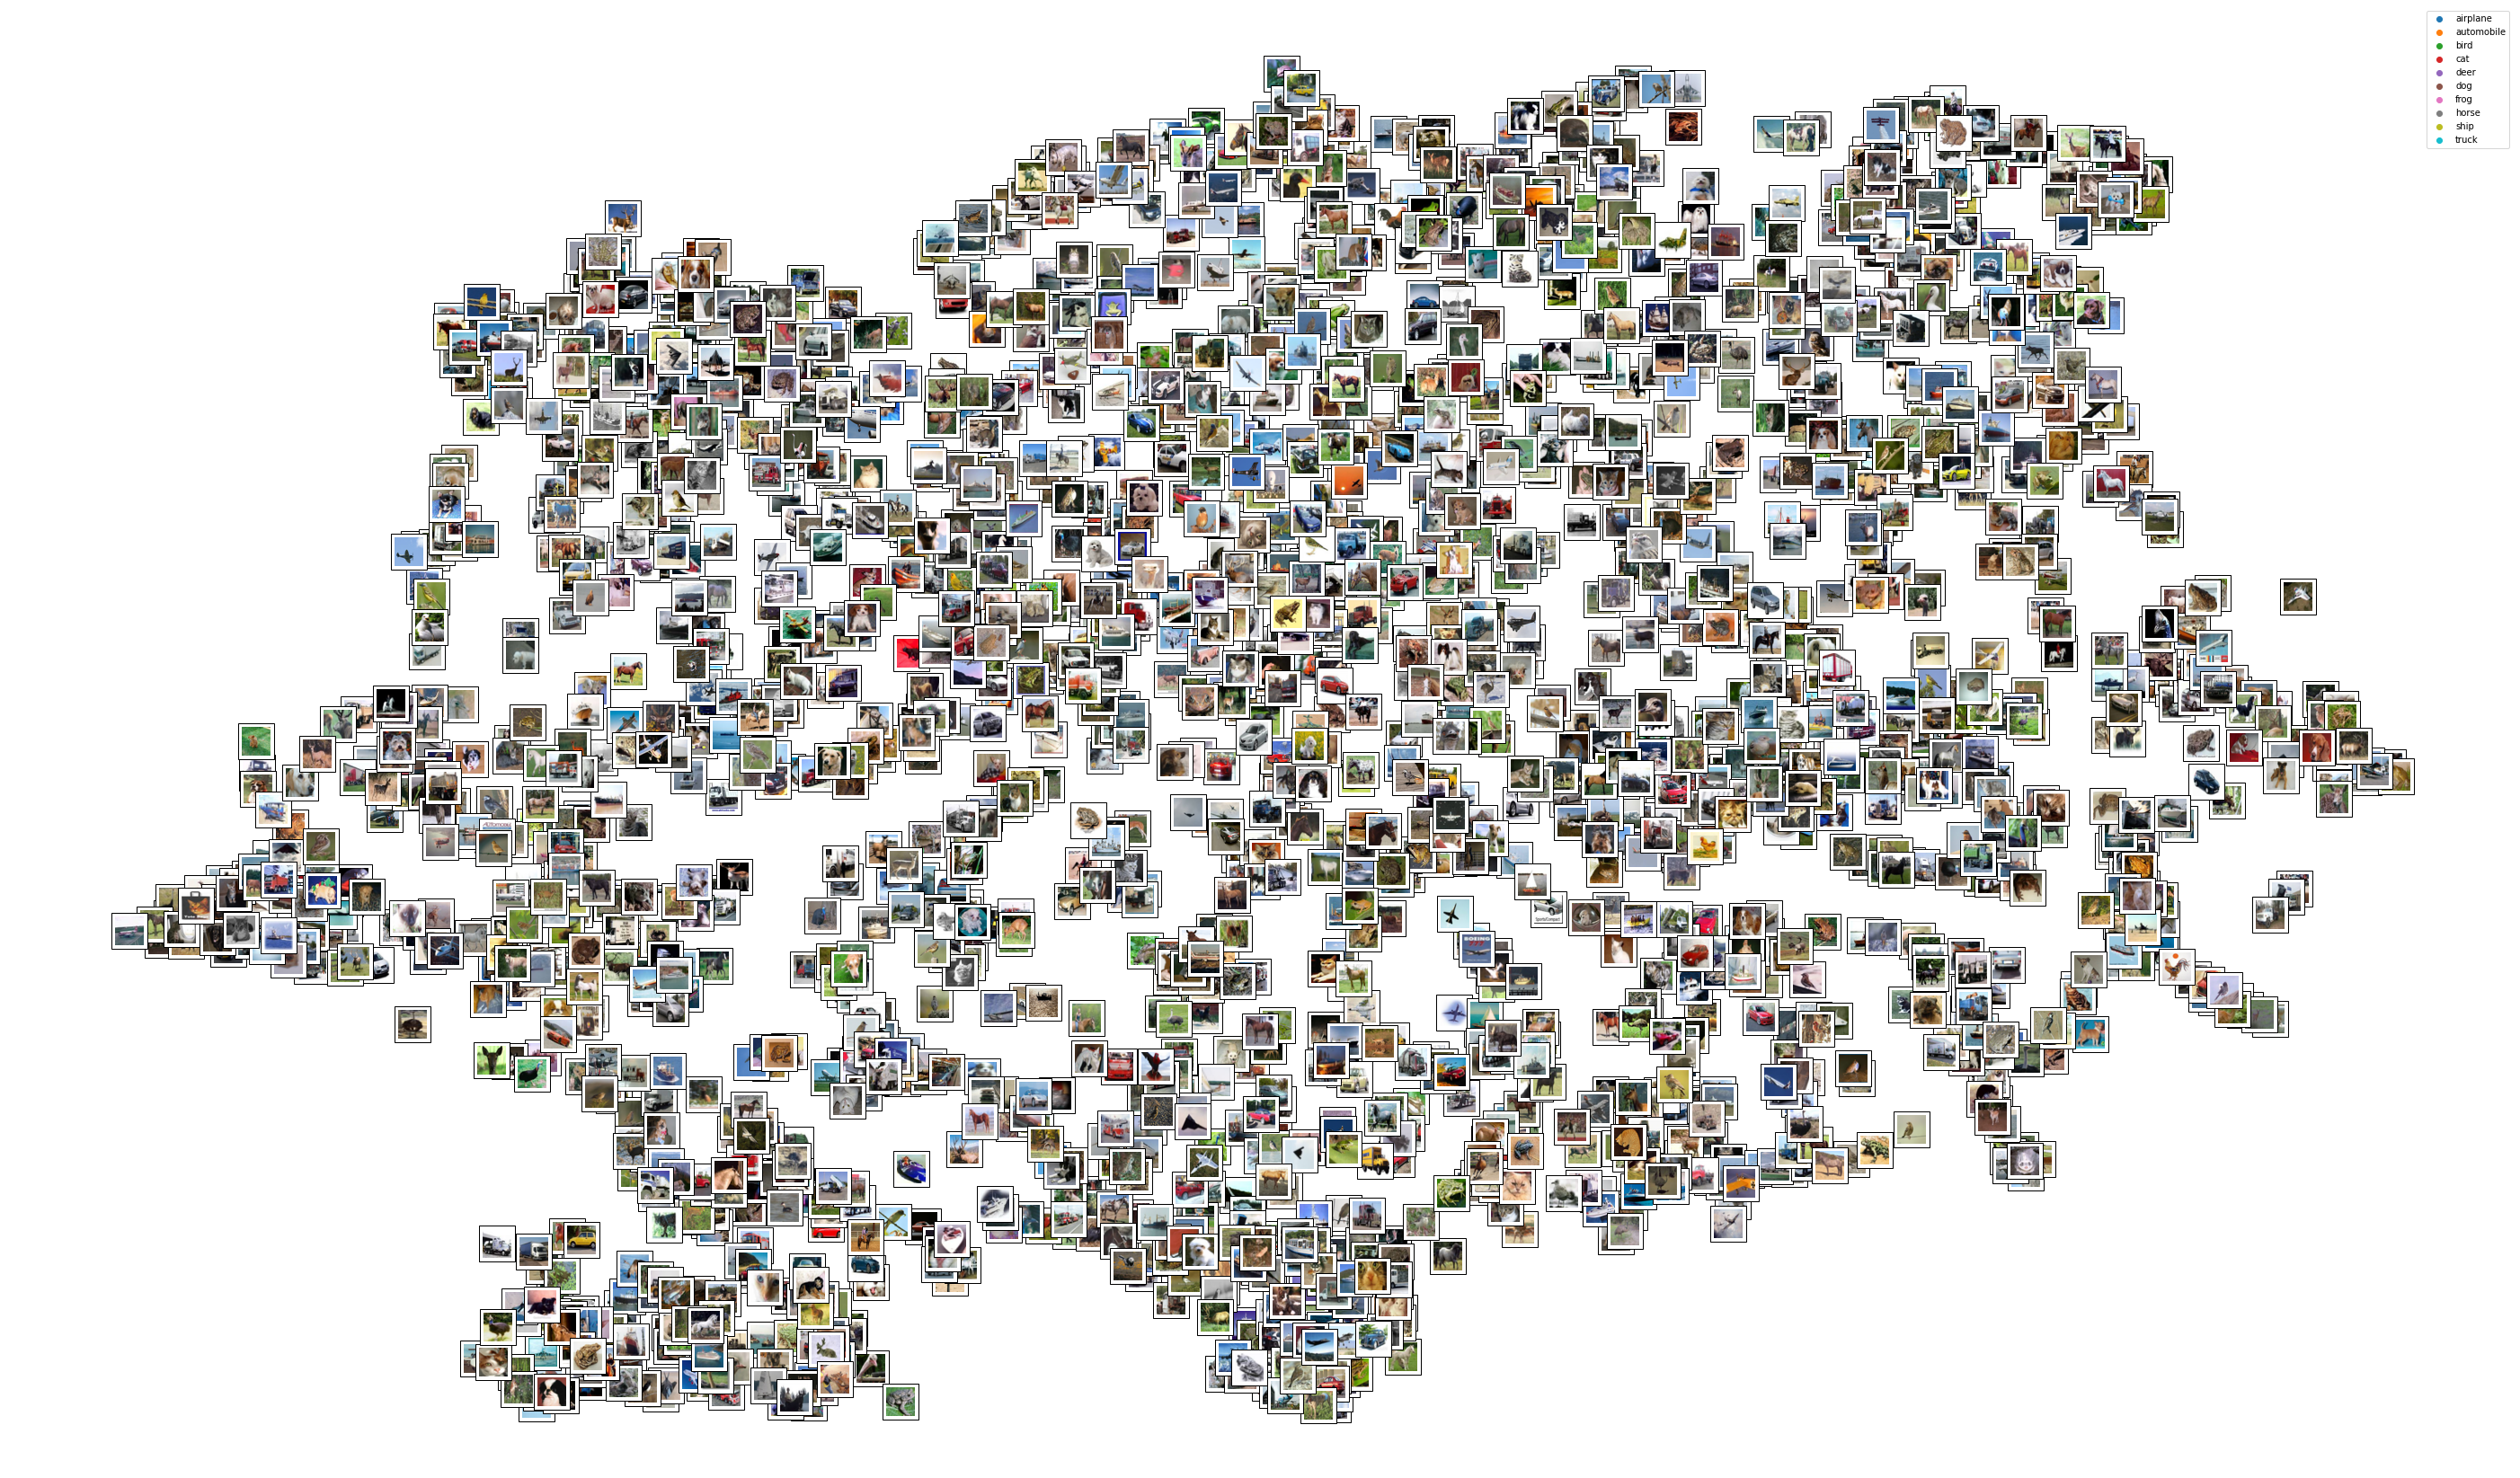

In [85]:
cmap_4 = plt.cm.tab10
plt.figure(figsize=(50,30))
scatter_4 = plt.scatter(tsne_results_4[:,0],tsne_results_4[:,1], c=y_valid_split[:3250], s=10, cmap=cmap_4)
plt.legend(handles=scatter_4.legend_elements()[0], labels=class_names)

image_positions = np.array([[1., 1.]])
for index, position in enumerate(tsne_results_4):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_train[index], cmap="binary"),
            position, bboxprops={"lw": 1})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

#### Predictions

In [86]:
model_4 = tf.keras.models.load_model('CNN_model_4.h5')
preds_4 = model_4.predict(x_test_norm)
preds_4.shape

313/313 [==============================] - 1s 3ms/step


(10000, 10)

In [87]:
cm_4 = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [88]:
df_4= pd.DataFrame(preds_4[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df_4.style.format("{:.2%}").background_gradient(cmap=cm_4)

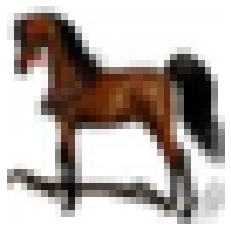

In [89]:
(_,_), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

img_4 = test_images[2004]
img_tensor_4 = image.img_to_array(img_4)
img_tensor_4 = np.expand_dims(img_tensor_4, axis=0)

class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

plt.imshow(img_4, cmap='viridis')
plt.axis('off')
plt.show()

In [90]:
# Extracts the outputs of the top 8 layers:
layer_outputs_4 = [layer.output for layer in model_4.layers[:8]]
# Creates a model that will return these outputs, given the model input:
activation_model_4 = models.Model(inputs=model_4.input, outputs=layer_outputs_4)

In [91]:
activations_4 = activation_model_4.predict(img_tensor_4)
len(activations_4)

1/1 [==============================] - 0s 96ms/step


8

In [92]:
layer_names = []
for layer in model_4.layers:
    layer_names.append(layer.name)
    
layer_names

['conv2d_2',
 'max_pooling2d_2',
 'conv2d_3',
 'max_pooling2d_3',
 'conv2d_4',
 'max_pooling2d_4',
 'flatten_3',
 'dense_7',
 'batch_normalization',
 'dense_8']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


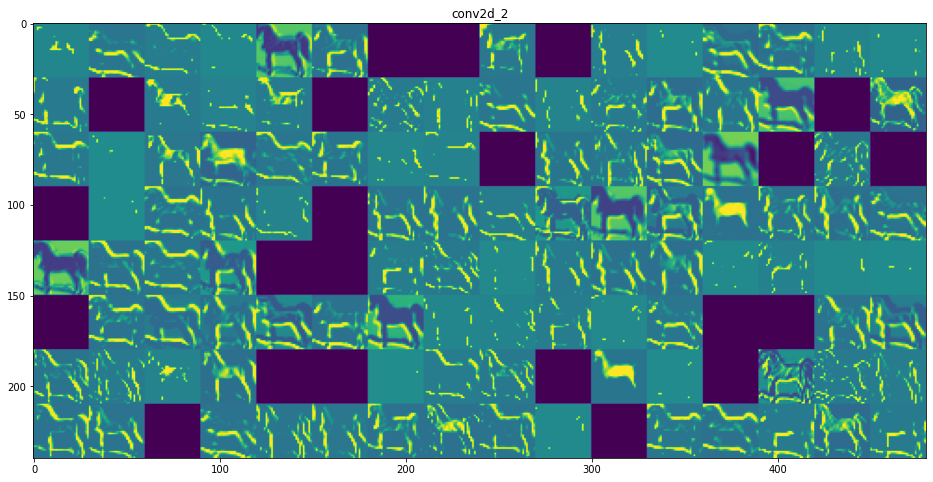

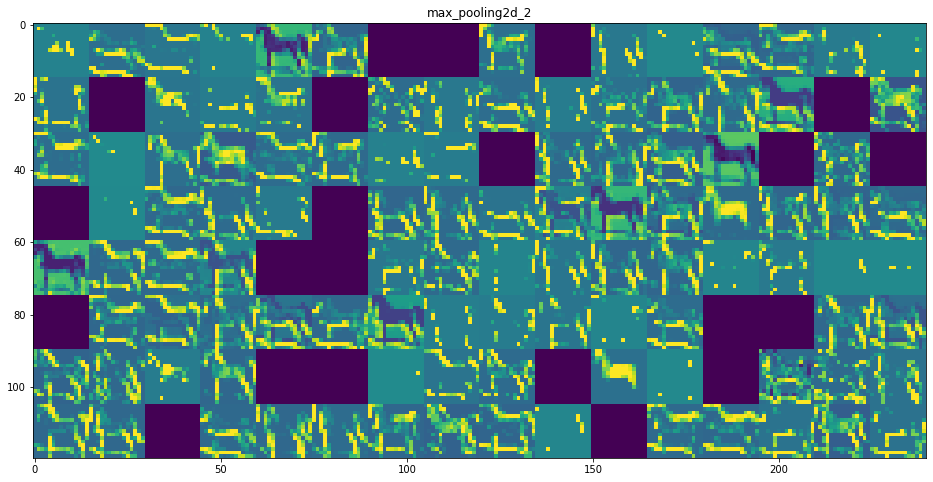

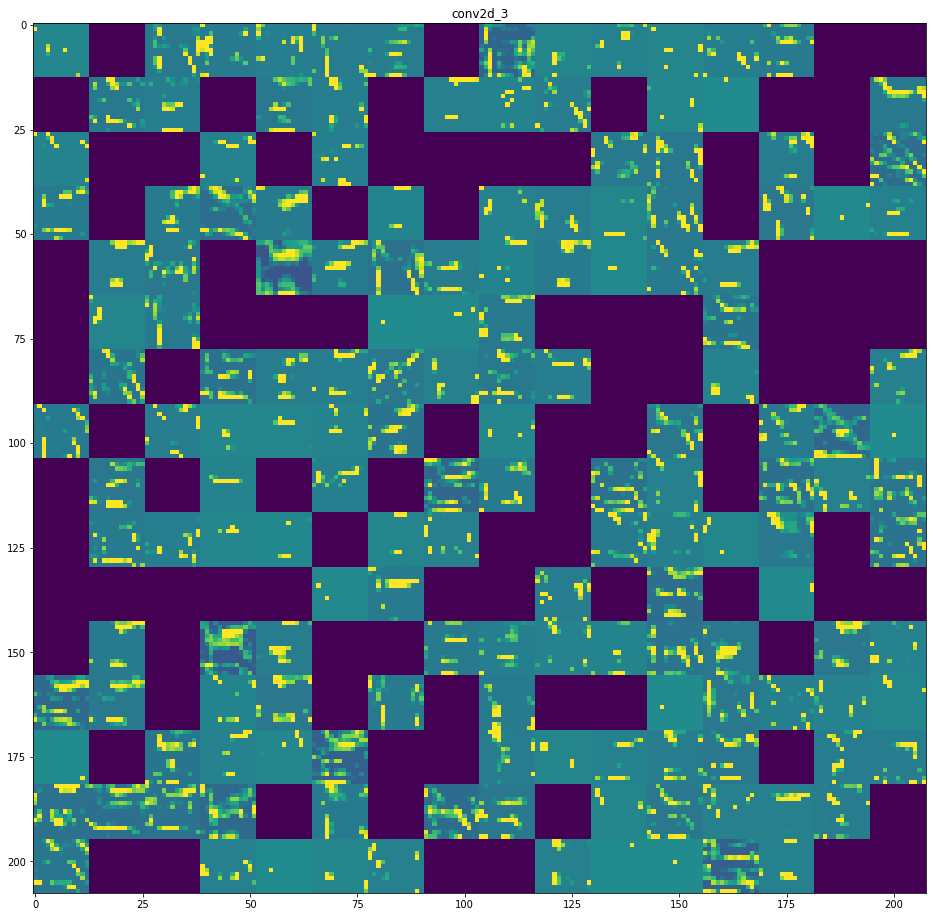

In [93]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_4.layers[:3]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations_4):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show();

##Experiment 5: Experiments 1-4 with regularization 
https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/

#### Model 5.1

Same as Model 1 with regularization - Dropout (0.25)

In [94]:
## Build
from keras import regularizers
from keras.layers.core import Dropout

model_5_1 = Sequential()
model_5_1.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_1.add(layers.Dense(units = 100, activation = "relu"))
model_5_1.add(Dropout(0.25))
model_5_1.add(layers.Dense(units = 150, activation = "relu"))
model_5_1.add(Dropout(0.25))
model_5_1.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 3072)              0         
                                                                 
 dense_9 (Dense)             (None, 100)               307300    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 150)               15150     
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 323,960
Trainable params: 323,960
Non-tr

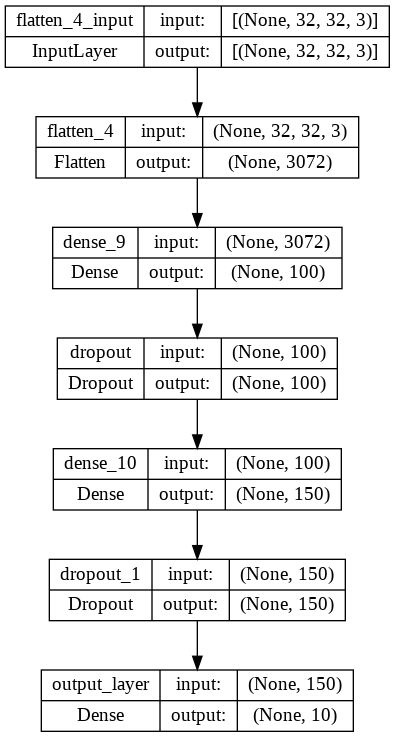

In [95]:
keras.utils.plot_model(model_5_1, "CIFAR_model.png", show_shapes=True) 

In [96]:
## Compile

model_5_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [97]:
## Train 
time = perf_counter()

history_5_1 = model_5_1.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_1.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 4ms/step - loss: 2.0629 - accuracy: 0.2238 - val_loss: 1.9069 - val_accuracy: 0.2916
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9539 - accuracy: 0.2725 - val_loss: 1.8398 - val_accuracy: 0.3318
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9152 - accuracy: 0.2915 - val_loss: 1.8328 - val_accuracy: 0.3422
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.8986 - accuracy: 0.3000 - val_loss: 1.8110 - val_accuracy: 0.3536
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.8828 - accuracy: 0.3035 - val_loss: 1.8453 - val_accuracy: 0.3406
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.8761 - accuracy: 0.3063 - val_loss: 1.7940 - val_accuracy: 0.3448
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.8602 - accuracy: 0.3169 - val_loss: 1.7886 - val_accuracy: 0.3576

In [98]:
time_5_1 = perf_counter() - time
print(time_5_1)

29.916706346999945


In [99]:
## Evaluate

model_5_1 = tf.keras.models.load_model("DNN_model_5_1.h5")
print(f"Test acc: {model_5_1.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.7322 - accuracy: 0.3857
Test acc: 0.386


#### Model 5.1.1

Same as Model 1 with regularization - Dropout (0.1)

In [100]:
## Build
from keras import regularizers
from keras.layers.core import Dropout

model_5_11 = Sequential()
model_5_11.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_11.add(layers.Dense(units = 100, activation = "relu"))
model_5_11.add(Dropout(0.1))
model_5_11.add(layers.Dense(units = 150, activation = "relu"))
model_5_11.add(Dropout(0.1))
model_5_11.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_11.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 3072)              0         
                                                                 
 dense_11 (Dense)            (None, 100)               307300    
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 150)               15150     
                                                                 
 dropout_3 (Dropout)         (None, 150)               0         
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 323,960
Trainable params: 323,960
Non-tr

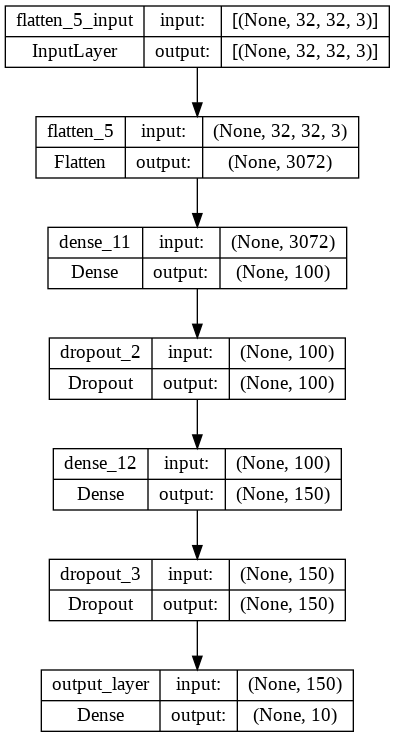

In [101]:
keras.utils.plot_model(model_5_11, "CIFAR_model.png", show_shapes=True) 

In [102]:
## Compile

model_5_11.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [103]:
## Train 
time = perf_counter()

history_5_11 = model_5_11.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_11.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 3ms/step - loss: 1.9478 - accuracy: 0.2820 - val_loss: 1.8061 - val_accuracy: 0.3404
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.8214 - accuracy: 0.3333 - val_loss: 1.7810 - val_accuracy: 0.3496
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.7613 - accuracy: 0.3596 - val_loss: 1.7011 - val_accuracy: 0.3870
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.7297 - accuracy: 0.3744 - val_loss: 1.6802 - val_accuracy: 0.4012
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.7061 - accuracy: 0.3826 - val_loss: 1.6821 - val_accuracy: 0.4000
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6906 - accuracy: 0.3862 - val_loss: 1.6995 - val_accuracy: 0.3784
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6800 - accuracy: 0.3907 - val_loss: 1.6708 - val_accuracy: 0.3988

In [104]:
time_5_11 = perf_counter() - time
print(time_5_11)

15.317320713000072


In [105]:
## Evaluate

model_5_11 = tf.keras.models.load_model("DNN_model_5_11.h5")
print(f"Test acc: {model_5_11.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.6352 - accuracy: 0.4157
Test acc: 0.416


#### Model 5.1.2

Same as Model 5.1 with regularization - Dropout (0.1) new hidden nodes (550, 300)

In [106]:
## Build
from keras import regularizers
from keras.layers.core import Dropout

model_5_12 = Sequential()
model_5_12.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_12.add(layers.Dense(units = 550, activation = "relu"))
model_5_12.add(Dropout(0.1))
model_5_12.add(layers.Dense(units = 300, activation = "relu"))
model_5_12.add(Dropout(0.1))
model_5_12.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_12.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 3072)              0         
                                                                 
 dense_13 (Dense)            (None, 550)               1690150   
                                                                 
 dropout_4 (Dropout)         (None, 550)               0         
                                                                 
 dense_14 (Dense)            (None, 300)               165300    
                                                                 
 dropout_5 (Dropout)         (None, 300)               0         
                                                                 
 output_layer (Dense)        (None, 10)                3010      
                                                                 
Total params: 1,858,460
Trainable params: 1,858,460
No

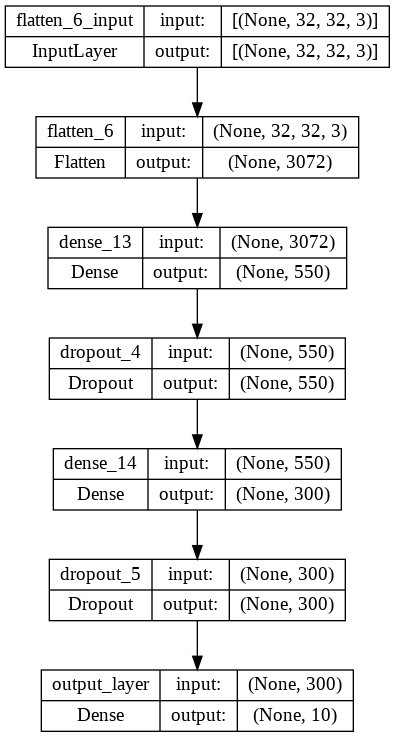

In [107]:
keras.utils.plot_model(model_5_12, "CIFAR_model.png", show_shapes=True) 

In [108]:
## Compile

model_5_12.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [109]:
## Train 
time = perf_counter()

history_5_12 = model_5_12.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_12.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 3ms/step - loss: 1.9339 - accuracy: 0.3029 - val_loss: 1.8263 - val_accuracy: 0.3430
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.7679 - accuracy: 0.3631 - val_loss: 1.6782 - val_accuracy: 0.3920
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6889 - accuracy: 0.3896 - val_loss: 1.6411 - val_accuracy: 0.4044
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6398 - accuracy: 0.4079 - val_loss: 1.6176 - val_accuracy: 0.4192
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6042 - accuracy: 0.4231 - val_loss: 1.6108 - val_accuracy: 0.4178
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5790 - accuracy: 0.4319 - val_loss: 1.5893 - val_accuracy: 0.4190
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5531 - accuracy: 0.4425 - val_loss: 1.5738 - val_accuracy: 0.4314

In [110]:
time_5_12 = perf_counter() - time
print(time_5_12)

58.827504379000175


In [111]:
## Evaluate

model_5_12 = tf.keras.models.load_model("DNN_model_5_12.h5")
print(f"Test acc: {model_5_12.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4222 - accuracy: 0.4925
Test acc: 0.493


#### Model 5.1.3

Same as Model 5.1.2 with regularization - Dropout (0.10) + added layer (250 nodes) + output activation = sigmoid

In [112]:
## Build
from keras import regularizers
from keras.layers.core import Dropout

model_5_13 = Sequential()
model_5_13.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_13.add(layers.Dense(units = 550, activation = "relu"))
model_5_13.add(Dropout(0.1))
model_5_13.add(layers.Dense(units = 300, activation = "relu"))
model_5_13.add(Dropout(0.1))
model_5_13.add(layers.Dense(units = 250, activation = "relu"))
model_5_13.add(Dropout(0.1))
model_5_13.add(layers.Dense(name = "output_layer", units = 10, activation = "sigmoid"))

model_5_13.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 3072)              0         
                                                                 
 dense_15 (Dense)            (None, 550)               1690150   
                                                                 
 dropout_6 (Dropout)         (None, 550)               0         
                                                                 
 dense_16 (Dense)            (None, 300)               165300    
                                                                 
 dropout_7 (Dropout)         (None, 300)               0         
                                                                 
 dense_17 (Dense)            (None, 250)               75250     
                                                                 
 dropout_8 (Dropout)         (None, 250)              

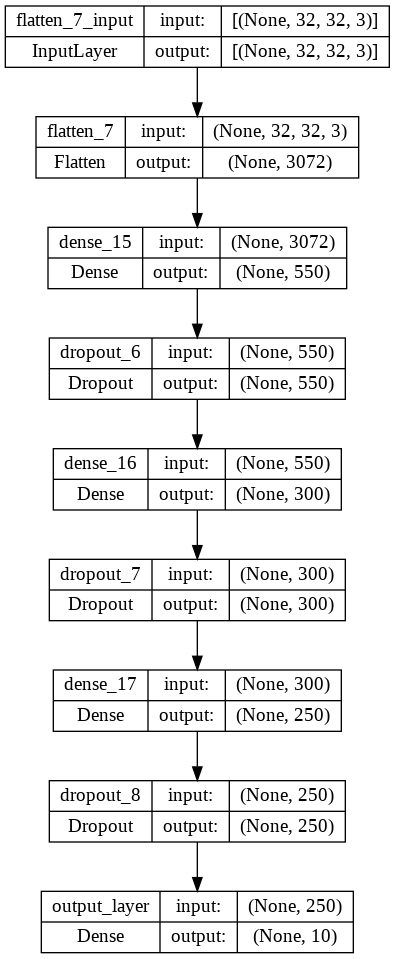

In [113]:
keras.utils.plot_model(model_5_13, "CIFAR_model.png", show_shapes=True) 

In [114]:
## Compile

model_5_13.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [115]:
## Train 
time = perf_counter()

history_5_13 = model_5_13.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_13.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 3ms/step - loss: 1.9461 - accuracy: 0.2883 - val_loss: 1.8064 - val_accuracy: 0.3396
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.7849 - accuracy: 0.3549 - val_loss: 1.7507 - val_accuracy: 0.3540
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.7185 - accuracy: 0.3802 - val_loss: 1.6865 - val_accuracy: 0.3940
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6811 - accuracy: 0.3945 - val_loss: 1.6766 - val_accuracy: 0.3976
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6484 - accuracy: 0.4046 - val_loss: 1.6718 - val_accuracy: 0.3870
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6196 - accuracy: 0.4187 - val_loss: 1.5962 - val_accuracy: 0.4190
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6014 - accuracy: 0.4201 - val_loss: 1.5493 - val_accuracy: 0.4352

In [116]:
time_5_13 = perf_counter() - time
print(time_5_13)

25.966179407000027


In [117]:
## Evaluate

model_5_13 = tf.keras.models.load_model("DNN_model_5_13.h5")
print(f"Test acc: {model_5_13.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.5066 - accuracy: 0.4634
Test acc: 0.463


#### Model 5.2 

Same as Model 2 with regularization

In [118]:
model_5_2 = Sequential()
model_5_2.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_2.add(layers.Dense(units = 100, activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model_5_2.add(layers.Dense(units = 250, activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model_5_2.add(layers.Dense(units = 150, activation = "relu", kernel_regularizer=regularizers.l2(0.01)))
model_5_2.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 3072)              0         
                                                                 
 dense_18 (Dense)            (None, 100)               307300    
                                                                 
 dense_19 (Dense)            (None, 250)               25250     
                                                                 
 dense_20 (Dense)            (None, 150)               37650     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 371,710
Trainable params: 371,710
Non-trainable params: 0
_________________________________________________________________


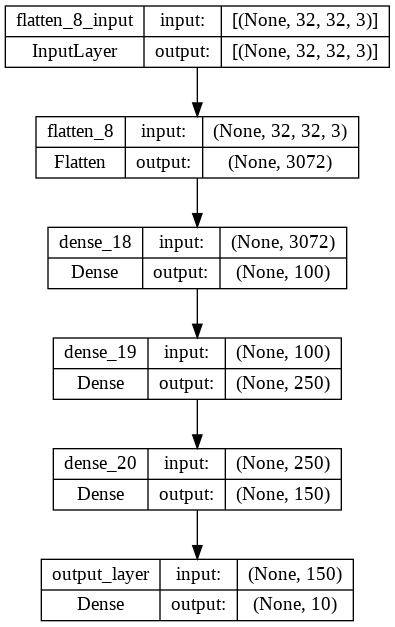

In [119]:
keras.utils.plot_model(model_5_2, "CIFAR_model.png", show_shapes=True) 

In [120]:
## Compile

model_5_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [121]:
## Train 
time = perf_counter()

history_5_2 = model_5_2.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_2.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 3ms/step - loss: 2.5547 - accuracy: 0.3058 - val_loss: 2.0264 - val_accuracy: 0.3218
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9877 - accuracy: 0.3321 - val_loss: 1.9864 - val_accuracy: 0.3262
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9296 - accuracy: 0.3474 - val_loss: 2.0316 - val_accuracy: 0.2932
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9252 - accuracy: 0.3465 - val_loss: 1.9414 - val_accuracy: 0.3346
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.9068 - accuracy: 0.3525 - val_loss: 1.9120 - val_accuracy: 0.3508
Epoch 6/200
704/704 [==============================] - 3s 4ms/step - loss: 1.8810 - accuracy: 0.3615 - val_loss: 1.8581 - val_accuracy: 0.3650
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.8786 - accuracy: 0.3613 - val_loss: 1.8888 - val_accuracy: 0.3520

In [122]:
time_5_2 = perf_counter() - time
print(time_5_2)

21.109129319999965


In [123]:
## Evaluate

model_5_2 = tf.keras.models.load_model("DNN_model_5_2.h5")
print(f"Test acc: {model_5_2.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.8274 - accuracy: 0.3789
Test acc: 0.379


#### Model 5.2.1

Same as Model 2 with bais regularization L2

In [124]:
from keras.regularizers import l2

model_5_21 = Sequential()
model_5_21.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_21.add(layers.Dense(units = 100, activation = "relu", bias_regularizer=l2(0.01)))
model_5_21.add(layers.Dense(units = 250, activation = "relu", bias_regularizer=l2(0.01)))
model_5_21.add(layers.Dense(units = 150, activation = "relu", bias_regularizer=l2(0.01)))
model_5_21.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_21.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 3072)              0         
                                                                 
 dense_21 (Dense)            (None, 100)               307300    
                                                                 
 dense_22 (Dense)            (None, 250)               25250     
                                                                 
 dense_23 (Dense)            (None, 150)               37650     
                                                                 
 output_layer (Dense)        (None, 10)                1510      
                                                                 
Total params: 371,710
Trainable params: 371,710
Non-trainable params: 0
_________________________________________________________________


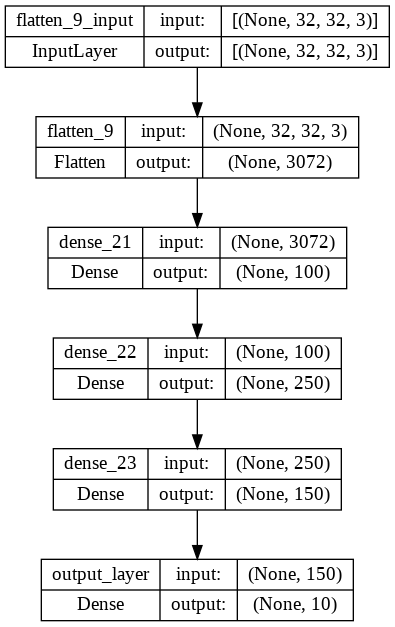

In [125]:
keras.utils.plot_model(model_5_21, "CIFAR_model.png", show_shapes=True) 

In [126]:
## Compile

model_5_21.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [127]:
## Train 
time = perf_counter()

history_5_21 = model_5_21.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_21.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 3ms/step - loss: 1.8728 - accuracy: 0.3214 - val_loss: 1.7542 - val_accuracy: 0.3688
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6840 - accuracy: 0.3943 - val_loss: 1.6516 - val_accuracy: 0.3978
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6075 - accuracy: 0.4252 - val_loss: 1.6192 - val_accuracy: 0.4134
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5541 - accuracy: 0.4417 - val_loss: 1.5563 - val_accuracy: 0.4346
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5147 - accuracy: 0.4560 - val_loss: 1.5208 - val_accuracy: 0.4532
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4920 - accuracy: 0.4658 - val_loss: 1.5344 - val_accuracy: 0.4464
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4707 - accuracy: 0.4736 - val_loss: 1.6119 - val_accuracy: 0.4198

In [128]:
time_5_21 = perf_counter() - time
print(time_5_21)

17.669689711000046


In [129]:
## Evaluate

model_5_21 = tf.keras.models.load_model("DNN_model_5_21.h5")
print(f"Test acc: {model_5_21.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.5013 - accuracy: 0.4642
Test acc: 0.464


#### Model 5.2.2

Same as Model 5.2.1 with bais regularization L2, updated nodes (550, 300, 250)

In [130]:
from keras.regularizers import l2

model_5_22 = Sequential()
model_5_22.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_22.add(layers.Dense(units = 550, activation = "relu", bias_regularizer=l2(0.01)))
model_5_22.add(layers.Dense(units = 300, activation = "relu", bias_regularizer=l2(0.01)))
model_5_22.add(layers.Dense(units = 250, activation = "relu", bias_regularizer=l2(0.01)))
model_5_22.add(layers.Dense(name = "output_layer", units = 10, activation = "softmax"))

model_5_22.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 3072)              0         
                                                                 
 dense_24 (Dense)            (None, 550)               1690150   
                                                                 
 dense_25 (Dense)            (None, 300)               165300    
                                                                 
 dense_26 (Dense)            (None, 250)               75250     
                                                                 
 output_layer (Dense)        (None, 10)                2510      
                                                                 
Total params: 1,933,210
Trainable params: 1,933,210
Non-trainable params: 0
_________________________________________________________________


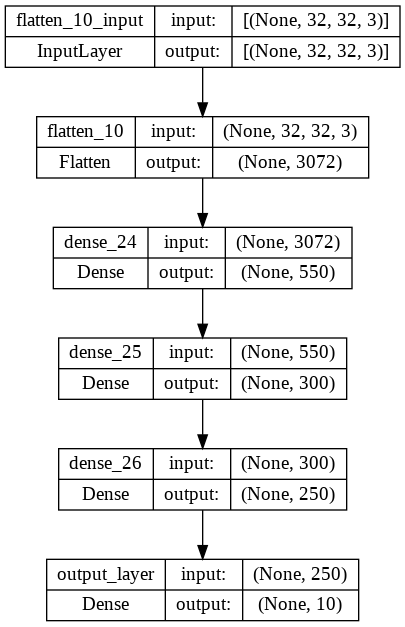

In [131]:
keras.utils.plot_model(model_5_22, "CIFAR_model.png", show_shapes=True) 

In [132]:
## Compile

model_5_22.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [133]:
## Train 
time = perf_counter()

history_5_22 = model_5_22.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_22.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 3ms/step - loss: 1.8762 - accuracy: 0.3204 - val_loss: 1.8043 - val_accuracy: 0.3446
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6920 - accuracy: 0.3908 - val_loss: 1.7014 - val_accuracy: 0.3806
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6026 - accuracy: 0.4251 - val_loss: 1.5865 - val_accuracy: 0.4256
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5439 - accuracy: 0.4465 - val_loss: 1.6113 - val_accuracy: 0.4178
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5014 - accuracy: 0.4633 - val_loss: 1.5293 - val_accuracy: 0.4476
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4669 - accuracy: 0.4757 - val_loss: 1.5311 - val_accuracy: 0.4518
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4305 - accuracy: 0.4894 - val_loss: 1.5073 - val_accuracy: 0.4532

In [134]:
time_5_22 = perf_counter() - time
print(time_5_22)

47.508284428000024


In [135]:
## Evaluate

model_5_22 = tf.keras.models.load_model("DNN_model_5_22.h5")
print(f"Test acc: {model_5_22.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4379 - accuracy: 0.4963
Test acc: 0.496


#### Model 5.2.3

Same as Model 5.2.2 with dropout - 0.1 + output activation = sigmoid

In [136]:
from keras.regularizers import l2

model_5_23 = Sequential()
model_5_23.add(keras.layers.Flatten(input_shape = [32, 32, 3]))
model_5_23.add(layers.Dense(units = 550, activation = "relu", bias_regularizer=l2(0.01)))
model_5_13.add(Dropout(0.1))
model_5_23.add(layers.Dense(units = 300, activation = "relu", bias_regularizer=l2(0.01)))
model_5_13.add(Dropout(0.1))
model_5_23.add(layers.Dense(units = 250, activation = "relu", bias_regularizer=l2(0.01)))
model_5_13.add(Dropout(0.1))
model_5_23.add(layers.Dense(name = "output_layer", units = 10, activation = "sigmoid"))

model_5_23.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 3072)              0         
                                                                 
 dense_27 (Dense)            (None, 550)               1690150   
                                                                 
 dense_28 (Dense)            (None, 300)               165300    
                                                                 
 dense_29 (Dense)            (None, 250)               75250     
                                                                 
 output_layer (Dense)        (None, 10)                2510      
                                                                 
Total params: 1,933,210
Trainable params: 1,933,210
Non-trainable params: 0
_________________________________________________________________


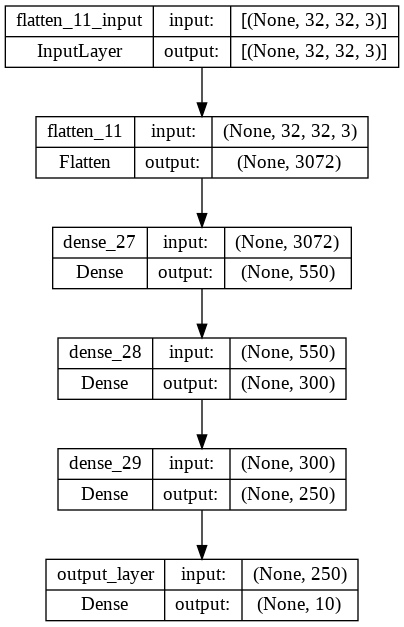

In [137]:
keras.utils.plot_model(model_5_23, "CIFAR_model.png", show_shapes=True) 

In [138]:
## Compile

model_5_23.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [139]:
## Train 
time = perf_counter()

history_5_23 = model_5_23.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model_5_23.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 3s 3ms/step - loss: 1.8616 - accuracy: 0.3257 - val_loss: 1.7902 - val_accuracy: 0.3478
Epoch 2/200
704/704 [==============================] - 2s 3ms/step - loss: 1.6842 - accuracy: 0.3963 - val_loss: 1.6153 - val_accuracy: 0.4176
Epoch 3/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5954 - accuracy: 0.4278 - val_loss: 1.7170 - val_accuracy: 0.3998
Epoch 4/200
704/704 [==============================] - 2s 3ms/step - loss: 1.5395 - accuracy: 0.4504 - val_loss: 1.5851 - val_accuracy: 0.4350
Epoch 5/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4927 - accuracy: 0.4648 - val_loss: 1.5440 - val_accuracy: 0.4490
Epoch 6/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4611 - accuracy: 0.4780 - val_loss: 1.5240 - val_accuracy: 0.4524
Epoch 7/200
704/704 [==============================] - 2s 3ms/step - loss: 1.4234 - accuracy: 0.4926 - val_loss: 1.5139 - val_accuracy: 0.4572

In [140]:
time_5_23 = perf_counter() - time
print(time_5_23)

29.88527212300005


In [141]:
## Evaluate

model_5_23 = tf.keras.models.load_model("DNN_model_5_23.h5")
print(f"Test acc: {model_5_23.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 2ms/step - loss: 1.4319 - accuracy: 0.4946
Test acc: 0.495


#### Model 5.3

Same as model 3 with regulaization

In [142]:
## Build CNN

model_5_3 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.3), # Layer 1 end
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.3), # Layer 2 end
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.softmax)       
])

model_5_3.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 15, 15, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 6, 6, 256)       

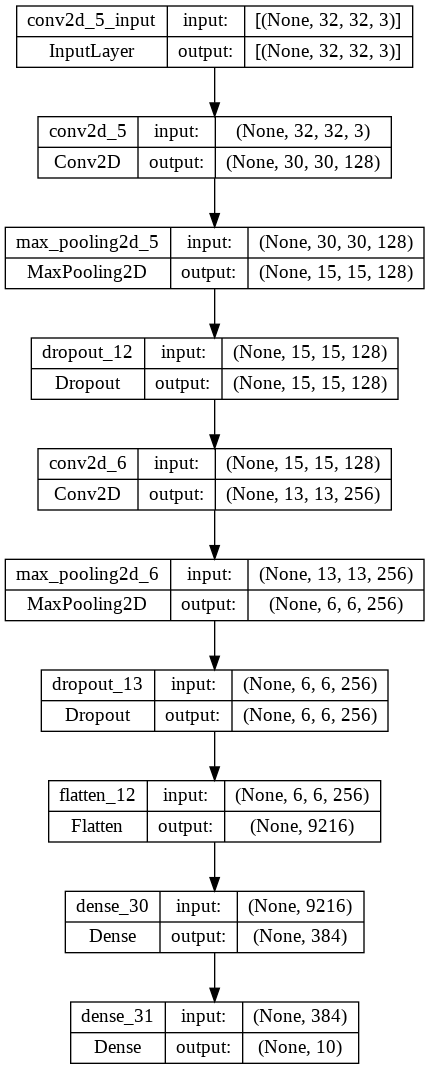

In [143]:
keras.utils.plot_model(model_5_3, "CIFAR10.png", show_shapes=True) 

In [144]:
## Compile

model_5_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [145]:
## Train 
time = perf_counter()

history_5_3 = model_5_3.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_3.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 8s 11ms/step - loss: 2.1643 - accuracy: 0.1733 - val_loss: 2.0931 - val_accuracy: 0.1706
Epoch 2/200
704/704 [==============================] - 7s 10ms/step - loss: 2.0078 - accuracy: 0.1841 - val_loss: 1.9679 - val_accuracy: 0.1858
Epoch 3/200
704/704 [==============================] - 7s 10ms/step - loss: 1.9397 - accuracy: 0.2095 - val_loss: 1.8802 - val_accuracy: 0.2634
Epoch 4/200
704/704 [==============================] - 7s 10ms/step - loss: 1.8490 - accuracy: 0.2691 - val_loss: 1.8029 - val_accuracy: 0.2906
Epoch 5/200
704/704 [==============================] - 7s 10ms/step - loss: 1.7724 - accuracy: 0.2974 - val_loss: 1.7654 - val_accuracy: 0.3016
Epoch 6/200
704/704 [==============================] - 7s 10ms/step - loss: 1.7194 - accuracy: 0.3270 - val_loss: 1.6850 - val_accuracy: 0.3438
Epoch 7/200
704/704 [==============================] - 7s 10ms/step - loss: 1.6157 - accuracy: 0.3703 - val_loss: 1.5871 - val_accuracy:

In [146]:
time_5_3 = perf_counter() - time
print(time_5_3)

296.98040856500006


In [147]:
## Evaluate

model_5_3 = tf.keras.models.load_model("CNN_model_5_3.h5")
print(f"Test acc: {model_5_3.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.0294 - accuracy: 0.6768
Test acc: 0.677


#### Model 5.3.1

Same as model 5.3 + updated dropout (0.10)

In [148]:
## Build CNN

model_5_31 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.1), # Layer 1 end
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.1), # Layer 2 end
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.softmax)       
])

model_5_31.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 dropout_14 (Dropout)        (None, 15, 15, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 6, 256)        0         
 2D)                                                             
                                                                 
 dropout_15 (Dropout)        (None, 6, 6, 256)       

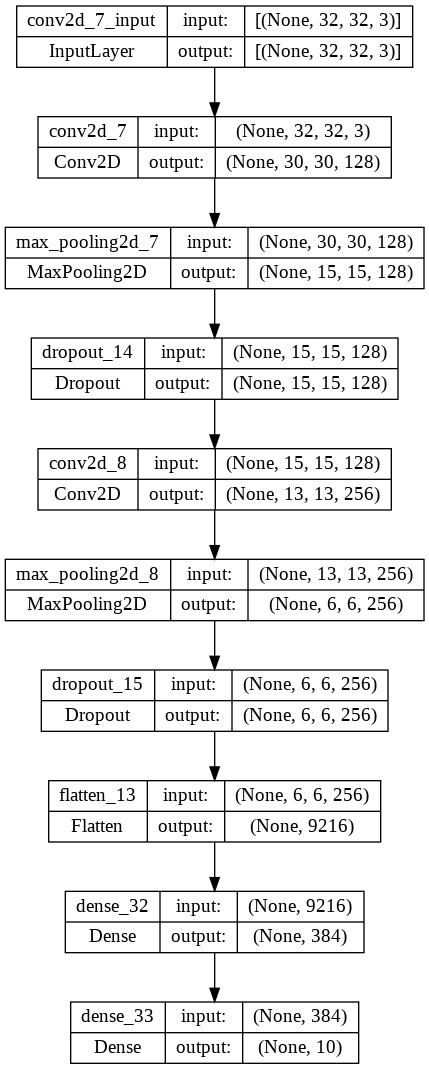

In [149]:
keras.utils.plot_model(model_5_31, "CIFAR10.png", show_shapes=True) 

In [150]:
## Compile

model_5_31.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [151]:
## Train 
time = perf_counter()

history_5_31 = model_5_31.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_31.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 8s 11ms/step - loss: 2.1919 - accuracy: 0.1869 - val_loss: 2.0727 - val_accuracy: 0.2162
Epoch 2/200
704/704 [==============================] - 7s 10ms/step - loss: 1.9884 - accuracy: 0.2282 - val_loss: 1.9257 - val_accuracy: 0.2412
Epoch 3/200
704/704 [==============================] - 7s 11ms/step - loss: 1.8726 - accuracy: 0.2816 - val_loss: 1.8043 - val_accuracy: 0.2964
Epoch 4/200
704/704 [==============================] - 7s 11ms/step - loss: 1.7526 - accuracy: 0.3289 - val_loss: 1.7080 - val_accuracy: 0.3272
Epoch 5/200
704/704 [==============================] - 8s 11ms/step - loss: 1.6666 - accuracy: 0.3516 - val_loss: 1.6189 - val_accuracy: 0.3492
Epoch 6/200
704/704 [==============================] - 8s 11ms/step - loss: 1.5974 - accuracy: 0.3672 - val_loss: 1.6081 - val_accuracy: 0.3492
Epoch 7/200
704/704 [==============================] - 7s 11ms/step - loss: 1.5353 - accuracy: 0.3934 - val_loss: 1.5109 - val_accuracy:

In [152]:
time_5_31 = perf_counter() - time
print(time_5_31)

344.47413257100015


In [153]:
## Evaluate

model_5_31 = tf.keras.models.load_model("CNN_model_5_31.h5")
print(f"Test acc: {model_5_31.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.0597 - accuracy: 0.6883
Test acc: 0.688


#### Model 5.3.2

Same as model 5.3.1 + updated nodes (250, 550, 250)

In [154]:
## Build CNN

model_5_32 = Sequential([
  Conv2D(filters=250, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.1), # Layer 1 end
  Conv2D(filters=550, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.1), # Layer 2 end
  Flatten(),
  Dense(units=250,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.softmax)       
])

model_5_32.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 250)       7000      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 250)      0         
 2D)                                                             
                                                                 
 dropout_16 (Dropout)        (None, 15, 15, 250)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 550)       1238050   
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 550)        0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 6, 6, 550)       

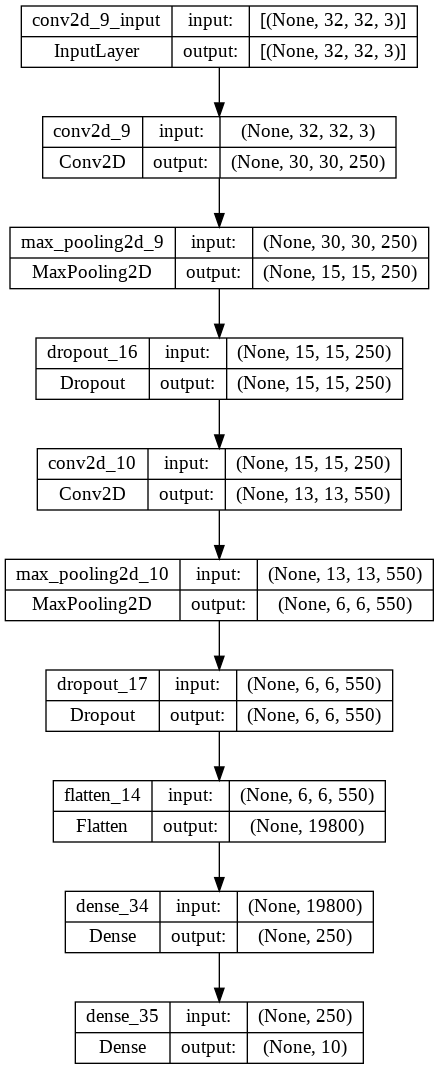

In [155]:
keras.utils.plot_model(model_5_32, "CIFAR10.png", show_shapes=True) 

In [156]:
## Compile

model_5_32.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [157]:
## Train 
time = perf_counter()

history_5_32 = model_5_32.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_32.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 17s 23ms/step - loss: 2.1585 - accuracy: 0.1712 - val_loss: 2.0962 - val_accuracy: 0.1726
Epoch 2/200
704/704 [==============================] - 16s 23ms/step - loss: 2.0028 - accuracy: 0.1945 - val_loss: 1.9600 - val_accuracy: 0.2092
Epoch 3/200
704/704 [==============================] - 16s 22ms/step - loss: 1.9111 - accuracy: 0.2418 - val_loss: 1.8719 - val_accuracy: 0.2588
Epoch 4/200
704/704 [==============================] - 16s 22ms/step - loss: 1.8170 - accuracy: 0.2742 - val_loss: 1.7881 - val_accuracy: 0.2756
Epoch 5/200
704/704 [==============================] - 16s 23ms/step - loss: 1.7456 - accuracy: 0.2930 - val_loss: 1.7507 - val_accuracy: 0.3058
Epoch 6/200
704/704 [==============================] - 16s 23ms/step - loss: 1.6957 - accuracy: 0.3111 - val_loss: 1.6999 - val_accuracy: 0.3002
Epoch 7/200
704/704 [==============================] - 16s 22ms/step - loss: 1.6554 - accuracy: 0.3259 - val_loss: 1.6626 - val_ac

In [158]:
time_5_32 = perf_counter() - time
print(time_5_32)

539.2554271240001


In [159]:
## Evaluate

model_5_32 = tf.keras.models.load_model("CNN_model_5_32.h5")
print(f"Test acc: {model_5_32.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 5ms/step - loss: 1.1389 - accuracy: 0.6237
Test acc: 0.624


#### Model 5.3.3

Same as model 5.3.1 + closeout activation = sigmoid

In [160]:
## Build CNN

model_5_33 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.1), # Layer 1 end
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.1), # Layer 2 end
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.sigmoid)       
])

model_5_33.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 15, 15, 128)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 6, 6, 256)       

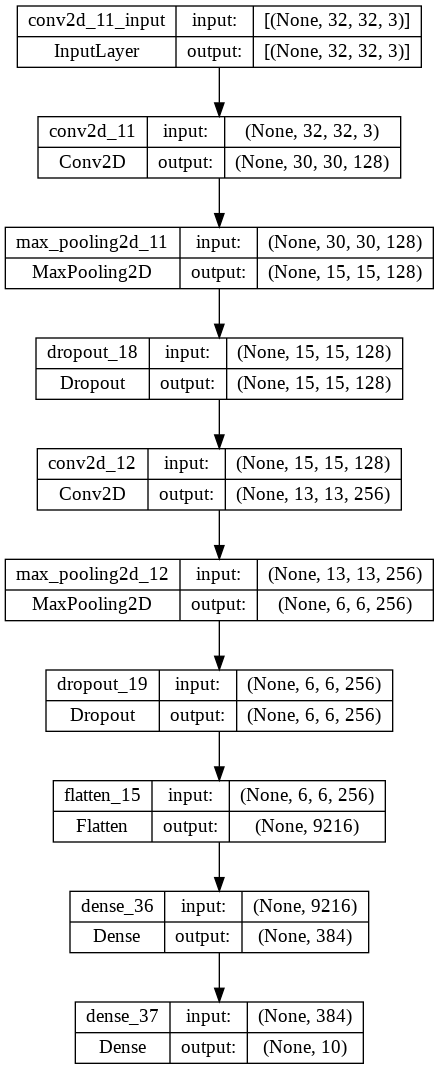

In [161]:
keras.utils.plot_model(model_5_33, "CIFAR10.png", show_shapes=True) 

In [162]:
## Compile

model_5_33.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [163]:
## Train 
time = perf_counter()

history_5_33 = model_5_33.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_33.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 8s 11ms/step - loss: 2.2193 - accuracy: 0.1700 - val_loss: 2.1139 - val_accuracy: 0.1674
Epoch 2/200
704/704 [==============================] - 7s 11ms/step - loss: 2.0571 - accuracy: 0.1788 - val_loss: 1.9960 - val_accuracy: 0.1894
Epoch 3/200
704/704 [==============================] - 7s 11ms/step - loss: 1.9766 - accuracy: 0.1946 - val_loss: 1.9447 - val_accuracy: 0.2144
Epoch 4/200
704/704 [==============================] - 7s 11ms/step - loss: 1.9071 - accuracy: 0.2262 - val_loss: 1.9169 - val_accuracy: 0.2462
Epoch 5/200
704/704 [==============================] - 7s 11ms/step - loss: 1.8458 - accuracy: 0.2711 - val_loss: 1.8084 - val_accuracy: 0.2812
Epoch 6/200
704/704 [==============================] - 7s 11ms/step - loss: 1.7863 - accuracy: 0.2916 - val_loss: 1.7677 - val_accuracy: 0.2866
Epoch 7/200
704/704 [==============================] - 8s 11ms/step - loss: 1.7373 - accuracy: 0.3074 - val_loss: 1.7299 - val_accuracy:

In [164]:
time_5_33 = perf_counter() - time
print(time_5_33)

431.30429106500014


In [165]:
## Evaluate

model_5_33 = tf.keras.models.load_model("CNN_model_5_33.h5")
print(f"Test acc: {model_5_33.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 1.0487 - accuracy: 0.6792
Test acc: 0.679


#### Model 5.3.4

Same as model 5.3 with udpated dropout (0.5)

In [166]:
## Build CNN

model_5_34 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]), # Layer 1 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.5), # Layer 1 end
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu), # Layer 2 start
  MaxPool2D((2, 2),strides=2), 
  Dropout(0.5), # Layer 2 end
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)), # Classification 
  Dense(units=10, activation=tf.nn.softmax)       
])

model_5_34.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, 15, 15, 128)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 dropout_21 (Dropout)        (None, 6, 6, 256)       

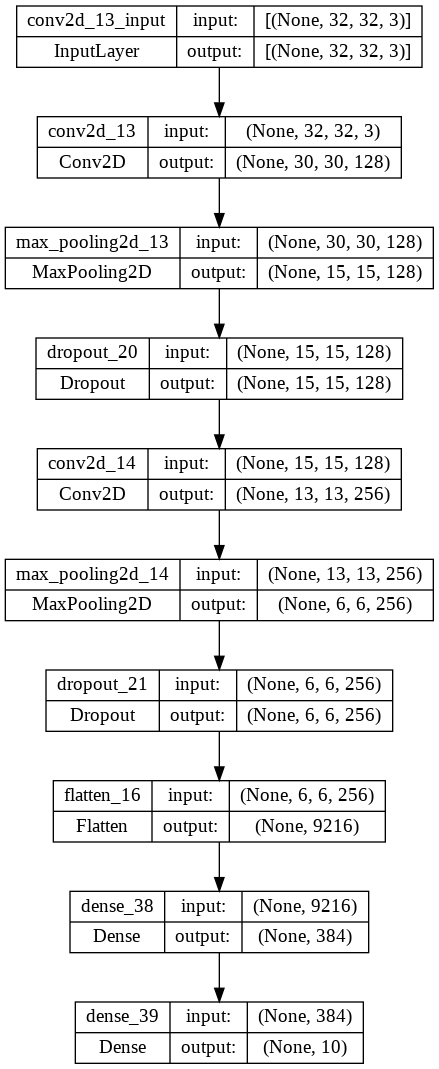

In [167]:
keras.utils.plot_model(model_5_34, "CIFAR10.png", show_shapes=True) 

In [168]:
## Compile

model_5_34.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [169]:
## Train 
time = perf_counter()

history_5_34 = model_5_34.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_34.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 8s 11ms/step - loss: 2.1717 - accuracy: 0.1936 - val_loss: 2.0986 - val_accuracy: 0.1988
Epoch 2/200
704/704 [==============================] - 7s 11ms/step - loss: 1.9937 - accuracy: 0.2256 - val_loss: 1.9873 - val_accuracy: 0.2286
Epoch 3/200
704/704 [==============================] - 7s 10ms/step - loss: 1.9103 - accuracy: 0.2528 - val_loss: 1.8611 - val_accuracy: 0.2882
Epoch 4/200
704/704 [==============================] - 7s 10ms/step - loss: 1.8241 - accuracy: 0.3103 - val_loss: 1.7672 - val_accuracy: 0.3314
Epoch 5/200
704/704 [==============================] - 7s 10ms/step - loss: 1.7425 - accuracy: 0.3373 - val_loss: 1.6892 - val_accuracy: 0.3536
Epoch 6/200
704/704 [==============================] - 7s 10ms/step - loss: 1.6818 - accuracy: 0.3520 - val_loss: 1.6644 - val_accuracy: 0.3554
Epoch 7/200
704/704 [==============================] - 7s 10ms/step - loss: 1.6382 - accuracy: 0.3586 - val_loss: 1.6120 - val_accuracy:

In [170]:
time_5_34 = perf_counter() - time
print(time_5_34)

258.343776144


In [171]:
## Evaluate

model_5_34 = tf.keras.models.load_model("CNN_model_5_34.h5")
print(f"Test acc: {model_5_34.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 2s 3ms/step - loss: 1.1930 - accuracy: 0.6064
Test acc: 0.606


#### Model 5.4 
Same as Model 4 with regularization

In [172]:
## Build CNN

model_5_4 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.3),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.3),
  Dense(units=10, activation=tf.nn.softmax)       
])
model_5_4.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 dropout_22 (Dropout)        (None, 15, 15, 128)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 dropout_23 (Dropout)        (None, 6, 6, 256)       

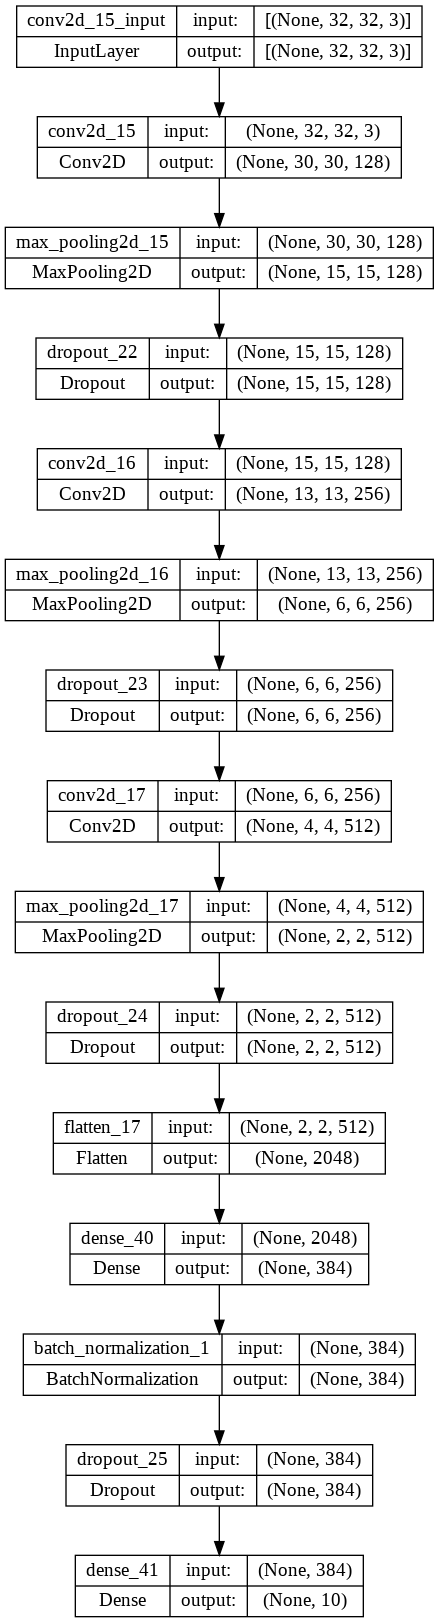

In [173]:
keras.utils.plot_model(model_5_4, "CIFAR10.png", show_shapes=True) 

In [174]:
## Compile
model_5_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [175]:
## Train
time = perf_counter()

history_5_4 = model_5_4.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_4.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 10s 13ms/step - loss: 1.6865 - accuracy: 0.4133 - val_loss: 1.4835 - val_accuracy: 0.4874
Epoch 2/200
704/704 [==============================] - 9s 12ms/step - loss: 1.3241 - accuracy: 0.5621 - val_loss: 1.1616 - val_accuracy: 0.6244
Epoch 3/200
704/704 [==============================] - 9s 12ms/step - loss: 1.1827 - accuracy: 0.6210 - val_loss: 1.1070 - val_accuracy: 0.6488
Epoch 4/200
704/704 [==============================] - 9s 12ms/step - loss: 1.0958 - accuracy: 0.6535 - val_loss: 0.9568 - val_accuracy: 0.6984
Epoch 5/200
704/704 [==============================] - 9s 12ms/step - loss: 1.0199 - accuracy: 0.6852 - val_loss: 0.9537 - val_accuracy: 0.7022
Epoch 6/200
704/704 [==============================] - 9s 12ms/step - loss: 0.9653 - accuracy: 0.7043 - val_loss: 0.8943 - val_accuracy: 0.7260
Epoch 7/200
704/704 [==============================] - 9s 12ms/step - loss: 0.9309 - accuracy: 0.7162 - val_loss: 0.8833 - val_accuracy

In [176]:
time_5_4 = perf_counter() - time
print(time_5_4)

131.2476639810002


In [177]:
## Evalute

model_5_4 = tf.keras.models.load_model("CNN_model_5_4.h5")
print(f"Test acc: {model_4.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.8884 - accuracy: 0.7197
Test acc: 0.720


#### Model 5.4.1
Same as Model 5.4 + updated dropout (0.1)

In [178]:
## Build CNN

model_5_41 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.1),
  Dense(units=10, activation=tf.nn.softmax)       
])
model_5_41.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 15, 15, 128)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 6, 6, 256)       

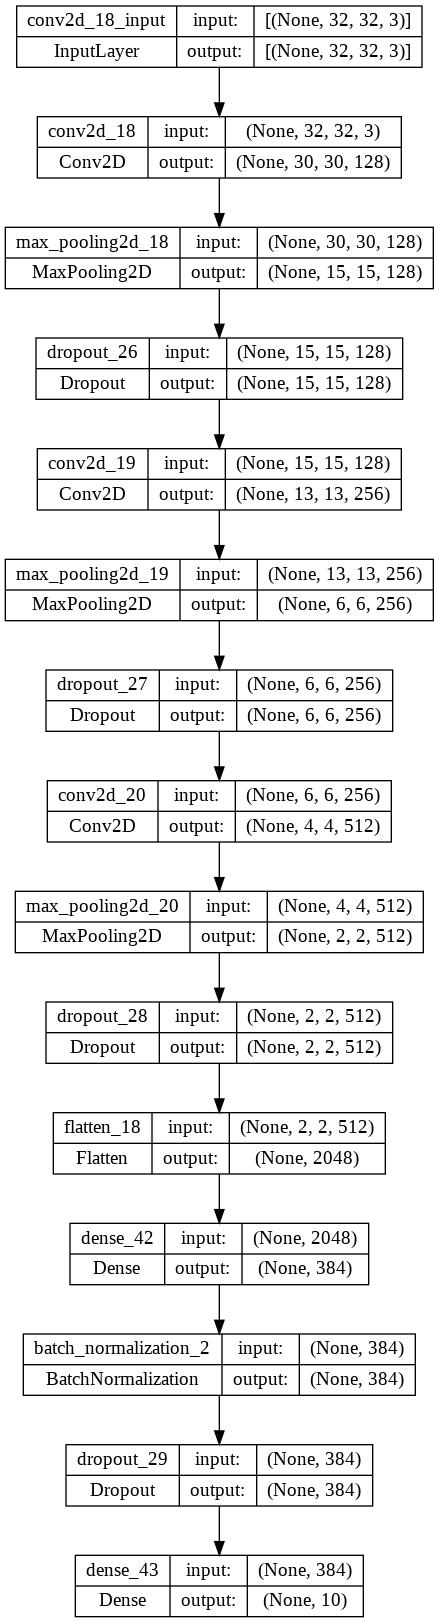

In [179]:
keras.utils.plot_model(model_5_41, "CIFAR10.png", show_shapes=True) 

In [180]:
## Compile
model_5_41.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [181]:
## Train
time = perf_counter()

history_5_41 = model_5_41.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_41.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 10s 13ms/step - loss: 1.5605 - accuracy: 0.4576 - val_loss: 1.3060 - val_accuracy: 0.5624
Epoch 2/200
704/704 [==============================] - 9s 12ms/step - loss: 1.1694 - accuracy: 0.6090 - val_loss: 1.0703 - val_accuracy: 0.6446
Epoch 3/200
704/704 [==============================] - 9s 12ms/step - loss: 0.9923 - accuracy: 0.6788 - val_loss: 1.0053 - val_accuracy: 0.6698
Epoch 4/200
704/704 [==============================] - 9s 12ms/step - loss: 0.8848 - accuracy: 0.7185 - val_loss: 0.9359 - val_accuracy: 0.6974
Epoch 5/200
704/704 [==============================] - 9s 12ms/step - loss: 0.7949 - accuracy: 0.7518 - val_loss: 0.8492 - val_accuracy: 0.7262
Epoch 6/200
704/704 [==============================] - 9s 12ms/step - loss: 0.7214 - accuracy: 0.7792 - val_loss: 0.8518 - val_accuracy: 0.7396
Epoch 7/200
704/704 [==============================] - 9s 12ms/step - loss: 0.6642 - accuracy: 0.8002 - val_loss: 0.8048 - val_accuracy

In [182]:
time_5_41 = perf_counter() - time
print(time_5_41)

130.93793225599984


In [183]:
## Evalute

model_5_41 = tf.keras.models.load_model("CNN_model_5_41.h5")
print(f"Test acc: {model_5_41.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.8382 - accuracy: 0.7557
Test acc: 0.756


#### Model 5.4.2
Same as Model 5.4.2 + L2 kernel regularizer

In [184]:
## Build CNN

model_5_42 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.1),
  Dense(units=10, activation=tf.nn.sigmoid)       
])
model_5_42.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 15, 15, 128)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 6, 6, 256)       

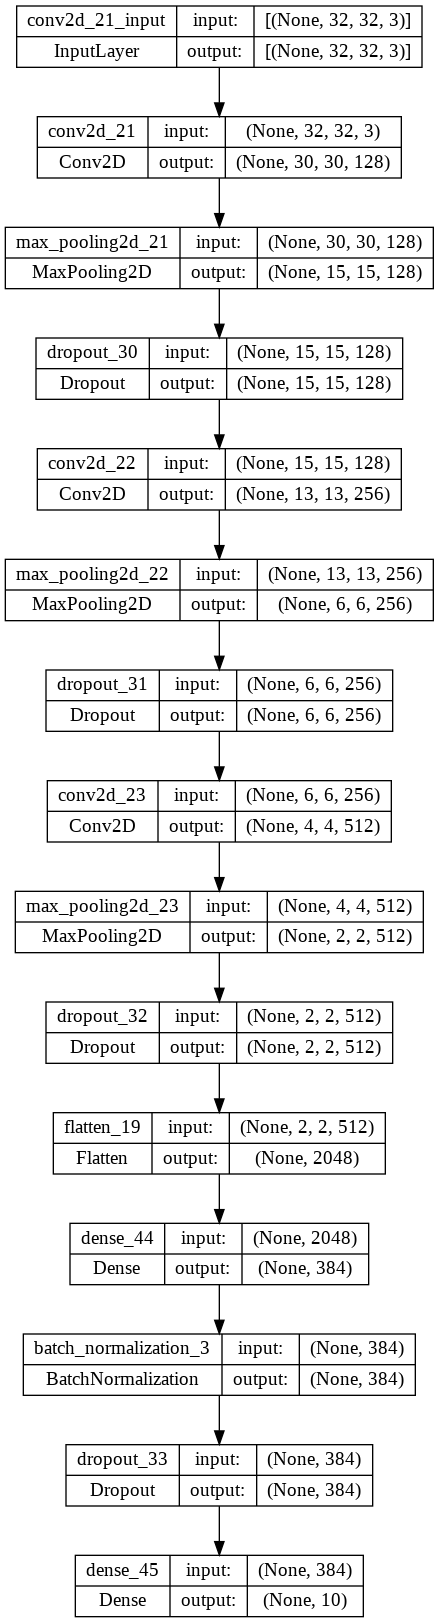

In [185]:
keras.utils.plot_model(model_5_42, "CIFAR10.png", show_shapes=True) 

In [186]:
## Compile
model_5_42.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [187]:
## Train
time = perf_counter()

history_5_42 = model_5_42.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_42.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 10s 13ms/step - loss: 1.6149 - accuracy: 0.4280 - val_loss: 1.4322 - val_accuracy: 0.5058
Epoch 2/200
704/704 [==============================] - 9s 12ms/step - loss: 1.1658 - accuracy: 0.6112 - val_loss: 1.3279 - val_accuracy: 0.5542
Epoch 3/200
704/704 [==============================] - 9s 12ms/step - loss: 0.9962 - accuracy: 0.6760 - val_loss: 0.9623 - val_accuracy: 0.6918
Epoch 4/200
704/704 [==============================] - 9s 12ms/step - loss: 0.8870 - accuracy: 0.7168 - val_loss: 1.0196 - val_accuracy: 0.6694
Epoch 5/200
704/704 [==============================] - 9s 12ms/step - loss: 0.7973 - accuracy: 0.7494 - val_loss: 0.8874 - val_accuracy: 0.7184
Epoch 6/200
704/704 [==============================] - 9s 12ms/step - loss: 0.7386 - accuracy: 0.7729 - val_loss: 0.8337 - val_accuracy: 0.7416
Epoch 7/200
704/704 [==============================] - 9s 12ms/step - loss: 0.6793 - accuracy: 0.7923 - val_loss: 0.8403 - val_accuracy

In [188]:
time_5_42 = perf_counter() - time
print(time_5_42)

131.48155922500064


In [189]:
## Evalute

model_5_42 = tf.keras.models.load_model("CNN_model_5_42.h5")
print(f"Test acc: {model_5_42.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 0.8213 - accuracy: 0.7643
Test acc: 0.764


#### Model 5.4.3
Same as Model 5.4.2 + updated output activation = sigmoid

In [190]:
## Build CNN

model_5_43 = Sequential([
  Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=x_train_norm.shape[1:]),
  MaxPool2D((2, 2),strides=2),
  Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, kernel_regularizer=l2(0.001)),
  MaxPool2D((2, 2),strides=2),
  Dropout(0.1),
  Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, kernel_regularizer=l2(0.001)),
  MaxPool2D((2, 2),strides=2),
  Flatten(),
  Dense(units=384,activation=tf.nn.softmax,kernel_regularizer=tf.keras.regularizers.L2(0.001)),
  BatchNormalization(),
  Dropout(0.1),
  Dense(units=10, activation=tf.nn.sigmoid)       
])
model_5_43.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 15, 15, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 13, 13, 256)       295168    
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 6, 6, 256)        0         
 g2D)                                                            
                                                                 
 dropout_34 (Dropout)        (None, 6, 6, 256)         0         
                                                                 
 conv2d_26 (Conv2D)          (None, 4, 4, 512)       

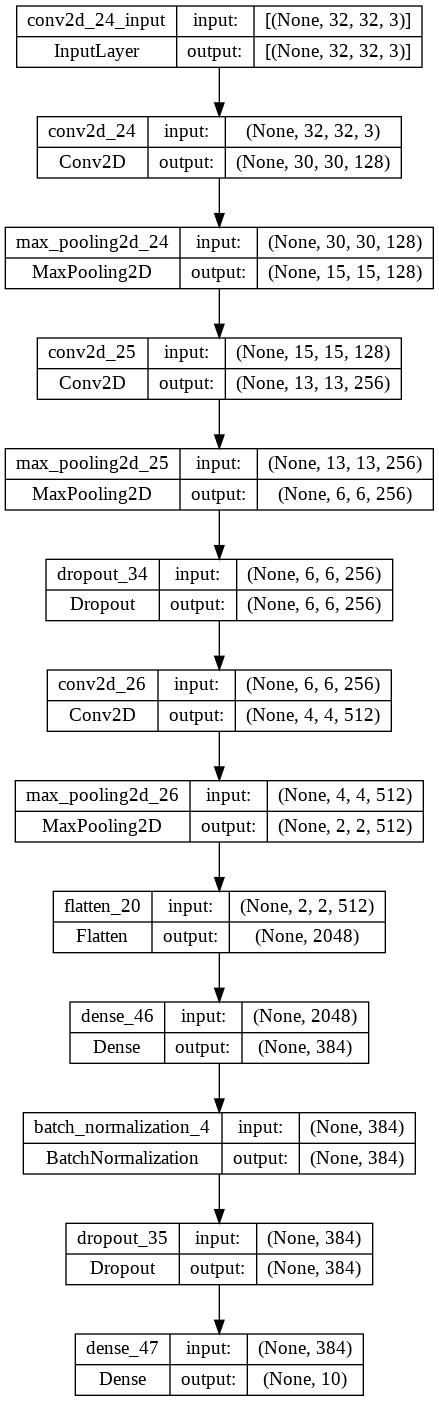

In [191]:
keras.utils.plot_model(model_5_43, "CIFAR10.png", show_shapes=True) 

In [192]:
## Compile
model_5_43.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [193]:
## Train
time = perf_counter()

history_5_43 = model_5_43.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=64
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("CNN_model_5_43.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    ]                                                                                                           
                   )

Epoch 1/200
704/704 [==============================] - 10s 12ms/step - loss: 1.7795 - accuracy: 0.3826 - val_loss: 2.5761 - val_accuracy: 0.2600
Epoch 2/200
704/704 [==============================] - 8s 12ms/step - loss: 1.4049 - accuracy: 0.5525 - val_loss: 1.4274 - val_accuracy: 0.5484
Epoch 3/200
704/704 [==============================] - 8s 12ms/step - loss: 1.2677 - accuracy: 0.6215 - val_loss: 1.4532 - val_accuracy: 0.5506
Epoch 4/200
704/704 [==============================] - 9s 12ms/step - loss: 1.1796 - accuracy: 0.6627 - val_loss: 1.2566 - val_accuracy: 0.6266
Epoch 5/200
704/704 [==============================] - 9s 12ms/step - loss: 1.1188 - accuracy: 0.6913 - val_loss: 1.1377 - val_accuracy: 0.6784
Epoch 6/200
704/704 [==============================] - 8s 12ms/step - loss: 1.0718 - accuracy: 0.7107 - val_loss: 1.2363 - val_accuracy: 0.6610
Epoch 7/200
704/704 [==============================] - 8s 12ms/step - loss: 1.0383 - accuracy: 0.7232 - val_loss: 1.1074 - val_accuracy

In [194]:
time_5_43 = perf_counter() - time
print(time_5_43)

86.25308791999942


In [195]:
## Evalute

model_5_43 = tf.keras.models.load_model("CNN_model_5_43.h5")
print(f"Test acc: {model_5_43.evaluate(x_test_norm, y_test)[1]:.3f}")

313/313 [==============================] - 1s 4ms/step - loss: 1.1355 - accuracy: 0.6958
Test acc: 0.696
